# Aim:
  To analyze historical taxi trip data and develop a comprehensive business plan for starting and expanding a taxi company, including loan repayment strategies, profit projection, and expansion plans, leveraging insights from data analysis and predictive modeling techniques.

In [47]:
# loading librarires
import requests
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import t

In [2]:
# URL of the Parquet file
url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'

# Download the Parquet file
response = requests.get(url)
parquet_file = pq.ParquetFile(BytesIO(response.content))

# Read data into a pandas DataFrame
df = parquet_file.read().to_pandas()

# Now you have your DataFrame ready for further processing
df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

### varibale means as follows
#### VendorID                               :  A code indicating the TPEP provider that provided the record.
 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc

#### tpep_pickup_datetime         : The date and time when the meter was engaged.

#### tpep_dropoff_datetime        : The date and time when the meter was disengaged.

#### Passenger_count                 : The number of passengers in the vehicle.
 This is a driver-entered value
 
#### Trip_distance                        : The elapsed trip distance in miles reported by the taximeter.
PULocationID           : TLC Taxi Zone in which the taximeter was engaged.
DOLocationID           : TLC Taxi Zone in which the taximeter was disengaged.
RateCodeID             : The final rate code in effect at the end of the trip.
                            1= Standard rate
                            2=JFK
                            3=Newark
                            4=Nassau or Westchester
                            5=Negotiated fare
                            6=Group ride
Store_and_fwd_flag     : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.
                            Y= store and forward trip
                            N= not a store and forward trip
Payment_type           : A numeric code signifying how the passenger paid for the trip.
                            1= Credit card
                            2= Cash
                            3= No charge
                            4= Dispute
                            5= Unknown
                            6= Voided trip
Fare_amount            : The time-and-distance fare calculated by the meter.
Extra                  : Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.
MTA_tax                : $0.50 MTA tax that is automatically triggered based on the metered rate in use.
mprovement_surcharge   : $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
Tip_amount             : Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
Tolls_amount           : Total amount of all tolls paid in trip.
Total_amount           : The total amount charged to passengers. Does not include cash tips.
Congestion_Surcharge   : Total amount collected in trip for NYS congestion surcharge.
Airport_fee            : $1.25 for pick up only at LaGuardia and John F. Kennedy Airports.

In [4]:
# our data is houge so we drop na directly
# droping nan's
df = df.dropna()

# Feature Extraction

## VendorID

In [5]:
df['VendorID'].value_counts()   

VendorID
2    2192313
1     802710
Name: count, dtype: int64

<Axes: xlabel='VendorID', ylabel='count'>

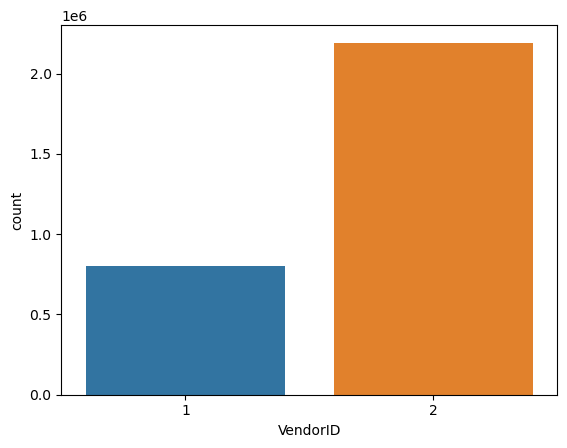

In [6]:
sns.countplot(data = df , x = 'VendorID')

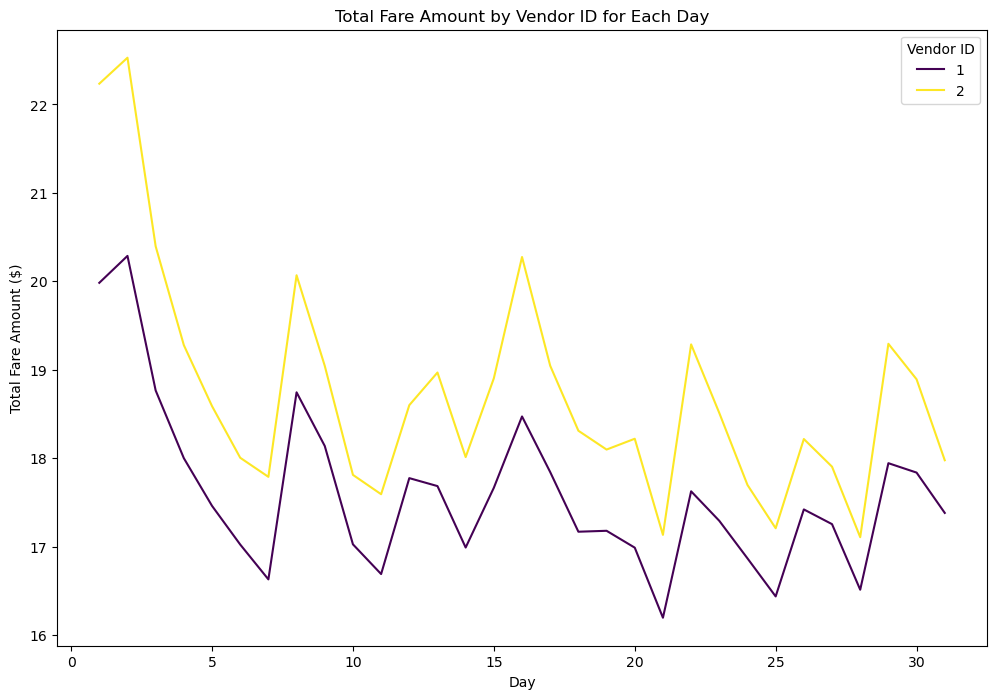

In [7]:
# Convert datetime column to day
df['day'] = df['tpep_pickup_datetime'].dt.day

# Calculate total fare amount for each VendorID for each day
total_fare_by_vendor_day = df.groupby(['day', 'VendorID'])['fare_amount'].sum().reset_index()
total_taxi_by_vendor_day = df.groupby(['day', 'VendorID']).size().reset_index()
total_taxi_by_vendor_day.columns = ['day', 'VendorID', 'total']
total_fare_by_vendor_day['fare_amount'] = total_fare_by_vendor_day['fare_amount']/total_taxi_by_vendor_day['total']
# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=total_fare_by_vendor_day, x='day', y='fare_amount', hue='VendorID', palette='viridis')
plt.xlabel('Day')
plt.ylabel('Total Fare Amount ($)')
plt.title('Total Fare Amount by Vendor ID for Each Day')
plt.legend(title='Vendor ID')
plt.show()

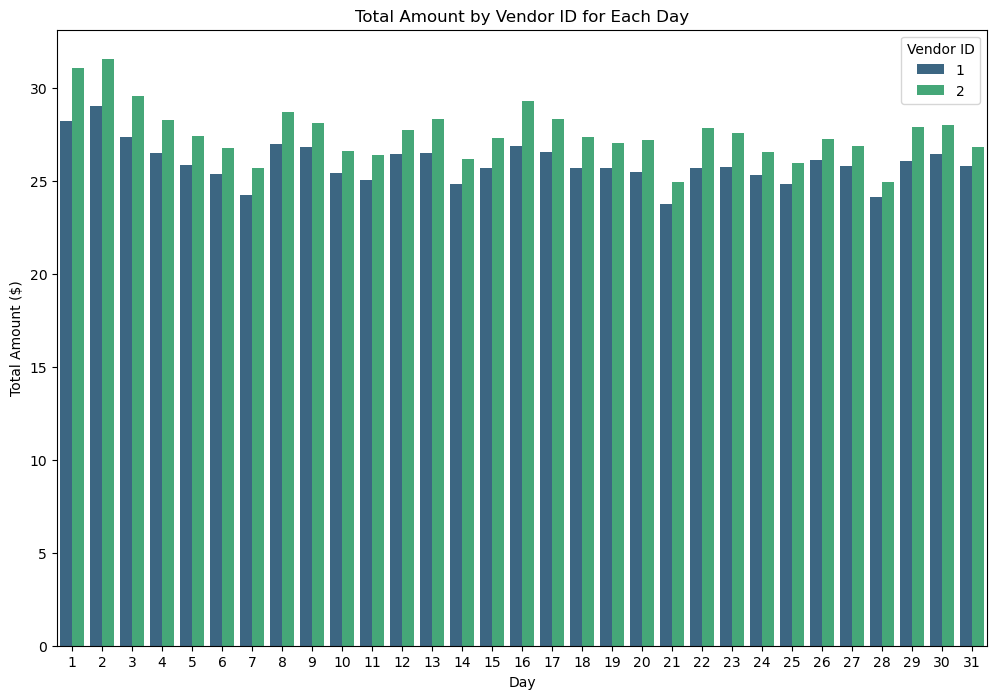

In [8]:
# Convert datetime column to day
df['day'] = df['tpep_pickup_datetime'].dt.day

# Calculate total total amount for each VendorID for each day
total_fare_by_vendor_day = df.groupby(['day', 'VendorID'])['total_amount'].sum().reset_index()
total_taxi_by_vendor_day = df.groupby(['day', 'VendorID']).size().reset_index()
total_taxi_by_vendor_day.columns = ['day', 'VendorID', 'total']
total_fare_by_vendor_day['total_amount'] = total_fare_by_vendor_day['total_amount']/total_taxi_by_vendor_day['total']
# Plotting
# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=total_fare_by_vendor_day, x='day', y='total_amount', hue='VendorID', palette='viridis')
plt.xlabel('Day')
plt.ylabel('Total Amount ($)')
plt.title('Total Amount by Vendor ID for Each Day')
plt.legend(title='Vendor ID')
plt.show()


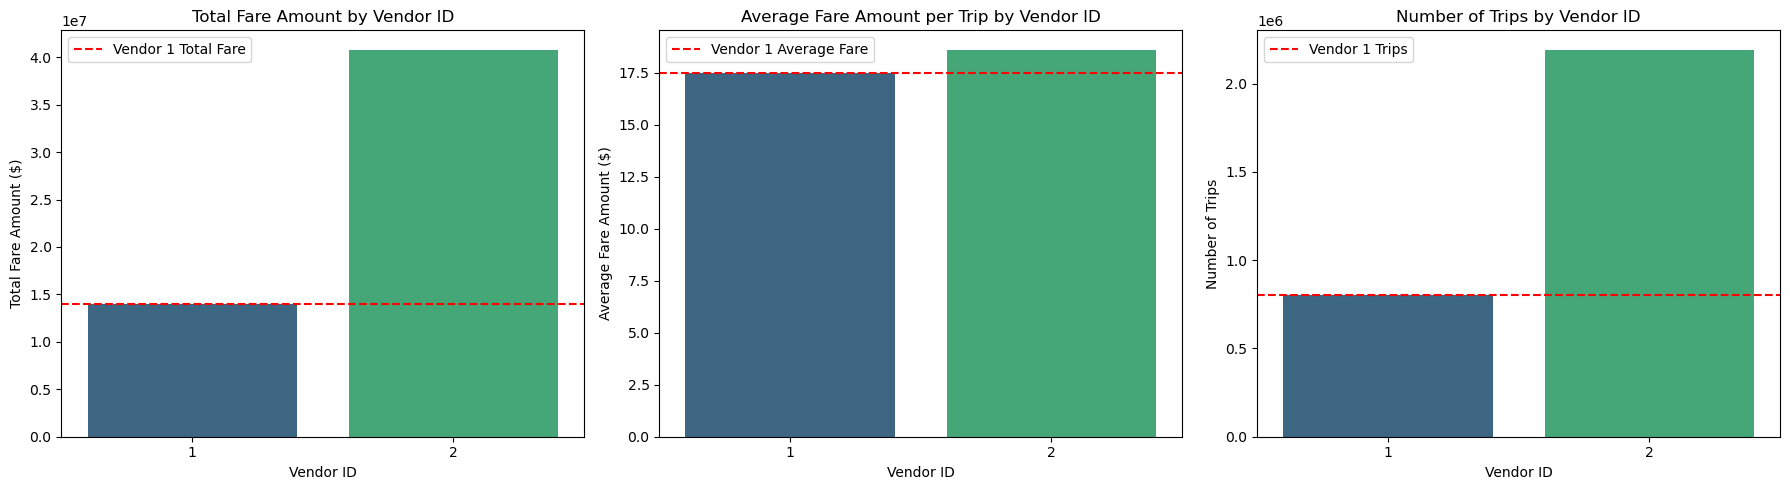

In [9]:

# Calculate total fare amount for each VendorID
total_fare_by_vendor = df.groupby('VendorID')['fare_amount'].sum()

# Calculate average fare amount per trip for each VendorID
average_fare_by_vendor = df.groupby('VendorID')['fare_amount'].mean()

# Calculate number of trips served by each VendorID
trip_count_by_vendor = df['VendorID'].value_counts()

# Plotting
plt.figure(figsize=(18, 5))

# Total Fare Amount
plt.subplot(1, 3, 1)
sns.barplot(x=total_fare_by_vendor.index, y=total_fare_by_vendor.values, palette='viridis')
plt.xlabel('Vendor ID')
plt.ylabel('Total Fare Amount ($)')
plt.title('Total Fare Amount by Vendor ID')
plt.axhline(total_fare_by_vendor[1], color='red', linestyle='--', label='Vendor 1 Total Fare')
plt.legend()

# Average Fare Amount per Trip
plt.subplot(1, 3, 2)
sns.barplot(x=average_fare_by_vendor.index, y=average_fare_by_vendor.values, palette='viridis')
plt.xlabel('Vendor ID')
plt.ylabel('Average Fare Amount ($)')
plt.title('Average Fare Amount per Trip by Vendor ID')
plt.axhline(average_fare_by_vendor[1], color='red', linestyle='--', label='Vendor 1 Average Fare')
plt.legend()

# Number of Trips
plt.subplot(1, 3, 3)
sns.barplot(x=trip_count_by_vendor.index, y=trip_count_by_vendor.values, palette='viridis')
plt.xlabel('Vendor ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Vendor ID')
plt.axhline(trip_count_by_vendor[1], color='red', linestyle='--', label='Vendor 1 Trips')
plt.legend()

plt.tight_layout()
plt.show()

Total Fare Amount: Show that while VendorID 2 handles more trips, VendorID 1 generates a comparable total fare amount.

Average Fare Amount per Trip: Highlight that VendorID 1 has a higher average fare amount per trip compared to VendorID 2.

Number of Trips: Emphasize that although VendorID 1 serves fewer trips, it still generates a significant total fare amount due to the higher average fare per trip.

In [10]:
df = df[df['VendorID'] == 1]
df.drop('VendorID',axis=1,inplace=True)
df = df[df['PULocationID'] != df['DOLocationID']]
co = df
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,day
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.9,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.00,1.0,20.85,0.0,1.25,1
11,2023-01-01 00:43:37,2023-01-01 01:17:18,4.0,7.3,1.0,N,79,264,1,33.8,3.50,0.5,7.75,0.00,1.0,46.55,2.5,0.00,1
17,2023-01-01 00:04:33,2023-01-01 00:19:22,1.0,4.5,1.0,N,113,255,1,20.5,3.50,0.5,4.00,0.00,1.0,29.50,2.5,0.00,1
18,2023-01-01 00:03:36,2023-01-01 00:09:36,3.0,1.2,1.0,N,237,239,2,8.6,3.50,0.5,0.00,0.00,1.0,13.60,2.5,0.00,1
19,2023-01-01 00:15:23,2023-01-01 00:29:41,2.0,2.5,1.0,N,143,229,2,15.6,3.50,0.5,0.00,0.00,1.0,20.60,2.5,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995011,2023-01-31 23:33:00,2023-01-31 23:42:16,1.0,5.4,1.0,N,138,226,1,22.6,7.25,0.5,6.25,0.00,1.0,37.60,0.0,1.25,31
2995012,2023-01-31 23:05:28,2023-01-31 23:35:30,1.0,13.9,1.0,N,132,91,1,54.1,2.25,0.5,10.00,0.00,1.0,67.85,0.0,1.25,31
2995016,2023-01-31 23:19:24,2023-01-31 23:32:07,1.0,7.4,1.0,N,138,75,1,29.6,7.25,0.5,8.95,6.55,1.0,53.85,0.0,1.25,31
2995018,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.9,99.0,N,228,159,1,50.5,0.00,0.5,0.00,0.00,1.0,52.00,0.0,0.00,31


## Tip_amount

In [11]:
# pip install sweetviz
# import the required libraries 
import sweetviz as sv
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

print("SweetViz Version : {}".format(sv.__version__))
# analyzing the dataset
report = sv.analyze(df)


SweetViz Version : 2.3.1


                                             |          | [  0%]   00:00 -> (? left)

In [86]:
report.show_html('Report.html')


Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# df = df[(df['tpep_pickup_datetime'].dt.month)==1]
df['store_and_fwd_flag'].value_counts()   # its aslo not useful

In [14]:
df.drop('store_and_fwd_flag',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 763534 entries, 3 to 2995021
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   tpep_pickup_datetime   763534 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  763534 non-null  datetime64[ns]
 2   passenger_count        763534 non-null  float64       
 3   trip_distance          763534 non-null  float64       
 4   RatecodeID             763534 non-null  float64       
 5   PULocationID           763534 non-null  int64         
 6   DOLocationID           763534 non-null  int64         
 7   payment_type           763534 non-null  int64         
 8   fare_amount            763534 non-null  float64       
 9   extra                  763534 non-null  float64       
 10  mta_tax                763534 non-null  float64       
 11  tip_amount             763534 non-null  float64       
 12  tolls_amount           763534 non-null  float64 

In [15]:
df[df['tip_amount'] < 0 ]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,day


Here some amount are negative as we know tip can't be negative .So , it is a TYPO

In [16]:
df[df['fare_amount'] < 0]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,day
1247281,2023-01-14 14:01:08,2023-01-14 14:39:29,1.0,0.0,1.0,265,238,1,-0.5,0.0,0.5,0.0,0.0,1.0,1.0,0.0,0.0,14


In [17]:
df[[ 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee']] = df[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee']].abs()

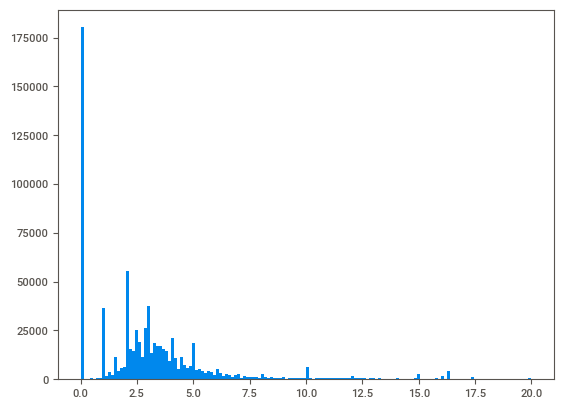

In [18]:
dataaa = df[df["tip_amount"] <= 20]["tip_amount"]

plt.hist(dataaa,bins=150);


In [19]:

# Calculate summary statistics
mean = np.mean(dataaa)
median = np.median(dataaa)
mode = np.argmax(np.bincount(dataaa))
min_value = np.min(dataaa)
max_value = np.max(dataaa)
range_value = np.ptp(dataaa)
variance = np.var(dataaa)
std_deviation = np.std(dataaa)

# Print summary statistics
print("Summary Statistics:")
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Range:", range_value)
print("Variance:", variance)
print("Standard Deviation:", std_deviation)

print("95% of trips:" , mean + 2 * std_deviation,mean - 2 * std_deviation)

Summary Statistics:
Mean: 3.079842405557762
Median: 2.65
Mode: 0
Minimum: 0.0
Maximum: 20.0
Range: 20.0
Variance: 10.094309884617488
Standard Deviation: 3.1771543690254473
95% of trips: 9.434151143608656 -3.274466332493133


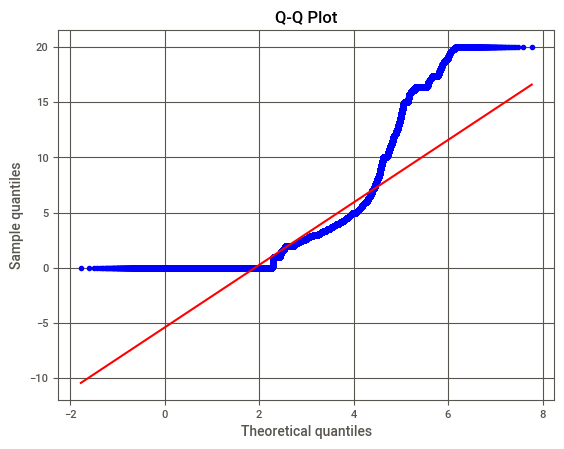

In [20]:
# Generate a Q-Q plot
stats.probplot(dataaa, dist="norm",sparams=(3,), plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.grid(True)
plt.show()

### Blue line deviate from red so it doesnt follow normal


### We assume that the tip amount follows gamma distribution with       rate parameter 3
### now we will check it

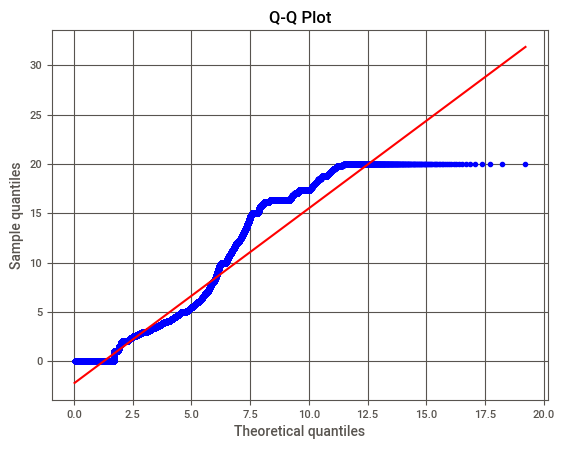

In [21]:
# Generate a Q-Q plot
stats.probplot(dataaa, dist="gamma",sparams=(3,), plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.grid(True)
plt.show()

### By above graph we can see it nearly follows gamma(3)



## Trip distance

In [63]:

# Sample data
data = df[df["trip_distance"] <= 25]["trip_distance"]
# Calculate summary statistics
mean = np.mean(data)
median = np.median(data)
mode = np.argmax(np.bincount(data))
min_value = np.min(data)
max_value = np.max(data)
range_value = np.ptp(data)
variance = np.var(data)
std_deviation = np.std(data)

# Print summary statistics
print("Summary Statistics:")
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Range:", range_value)
print("Variance:", variance)
print("Standard Deviation:", std_deviation)

taxi_dat = df
from scipy.stats import t

# Calculate 95% confidence interval for trip distance
n = len(taxi_dat['trip_distance'])
mean = taxi_dat['trip_distance'].mean()
std_err = taxi_dat['trip_distance'].std() / (n ** 0.5)
t_value = t.ppf(0.975, df=n-1)
margin_of_error = t_value * std_err
confidence_interval = (mean - margin_of_error, mean + margin_of_error)
print("95% Confidence Interval for Trip Distance:", confidence_interval)

Summary Statistics:
Mean: 3.226338205020213
Median: 1.8
Mode: 1
Minimum: 0.0
Maximum: 25.0
Range: 25.0
Variance: 16.271971044816883
Standard Deviation: 4.033853126331806
95% Confidence Interval for Trip Distance: (3.2684261174955616, 3.2874082002951344)


(0.0, 25.0)

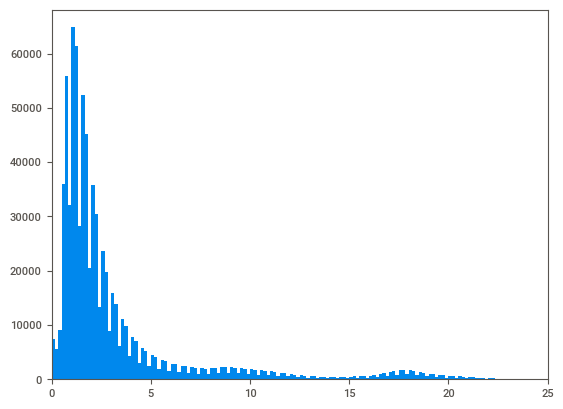

In [23]:
plt.hist(df[df["trip_distance"] <= 25]["trip_distance"],bins = 150)
plt.xlim(0,25)

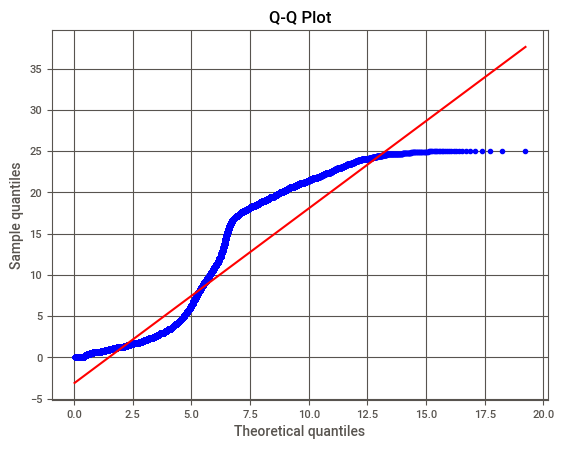

In [24]:
# Generate a Q-Q plot
stats.probplot(data, dist="gamma",sparams=(3,), plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.grid(True)
plt.show()

## By above graph we can see it nearly follows gamma(3)

## Trip Pickup Time and Dropoff time

In [64]:
# Assuming 'tpep_pickup_datetime' is a string representing datetime values
# If it's already in datetime format, you can skip this step
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract the day of the week from the pickup datetime
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()


from scipy.stats import ttest_ind

# Separate data for weekdays and weekends
weekday_trips = df.loc[df['pickup_day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'trip_distance']
weekend_trips = df.loc[df['pickup_day_of_week'].isin(['Saturday', 'Sunday']), 'trip_distance']

# Perform independent samples t-test
t_statistic, p_value = ttest_ind(weekday_trips, weekend_trips, equal_var=False)  # Setting equal_var=False for unequal variances
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in trip distance between weekdays and weekends.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in trip distance between weekdays and weekends.")

T-statistic: -8.736723447841165
P-value: 2.409194434789374e-18
Reject the null hypothesis: There is a significant difference in trip distance between weekdays and weekends.


In [25]:
dff = df["tpep_pickup_datetime"]
# Assuming your datetime data is in a Pandas Series
datetime_series = dff

# Convert the Series to datetime dtype
datetime_series = pd.to_datetime(datetime_series)

# Separate date and time components
date_component = datetime_series.dt.date
time_component = datetime_series.dt.time


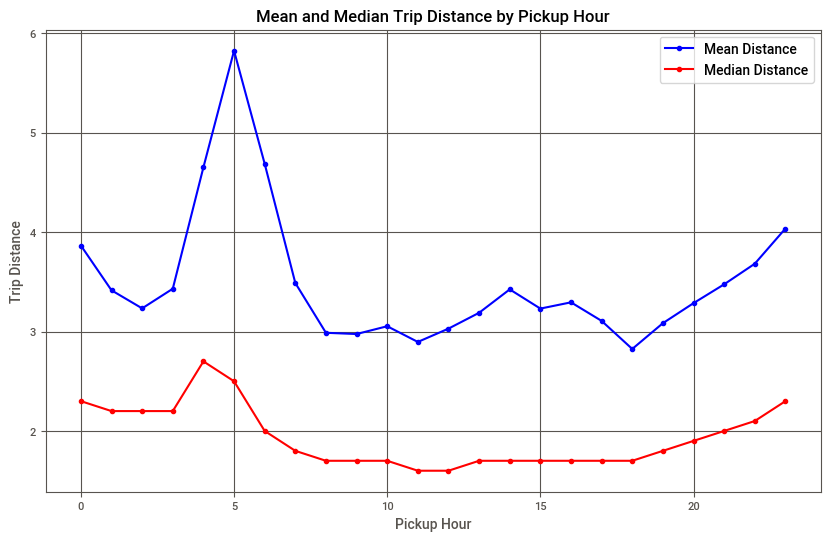

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df with columns 'pickup_datetime' and 'trip_distance'
# Convert 'pickup_datetime' to datetime if it's not already in datetime format
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract hour from 'pickup_datetime'
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Group by pickup hour and calculate mean and median trip distances
mean_distance_by_hour = df.groupby('pickup_hour')['trip_distance'].mean()
median_distance_by_hour = df.groupby('pickup_hour')['trip_distance'].median()

# Plotting the line plot for mean trip distances
plt.figure(figsize=(10, 6))
plt.plot(mean_distance_by_hour.index, mean_distance_by_hour, marker='o', color='b', label='Mean Distance')

# Plotting the line plot for median trip distances
plt.plot(median_distance_by_hour.index, median_distance_by_hour, marker='o', color='r', label='Median Distance')

# Adding labels and title
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Distance')
plt.title('Mean and Median Trip Distance by Pickup Hour')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


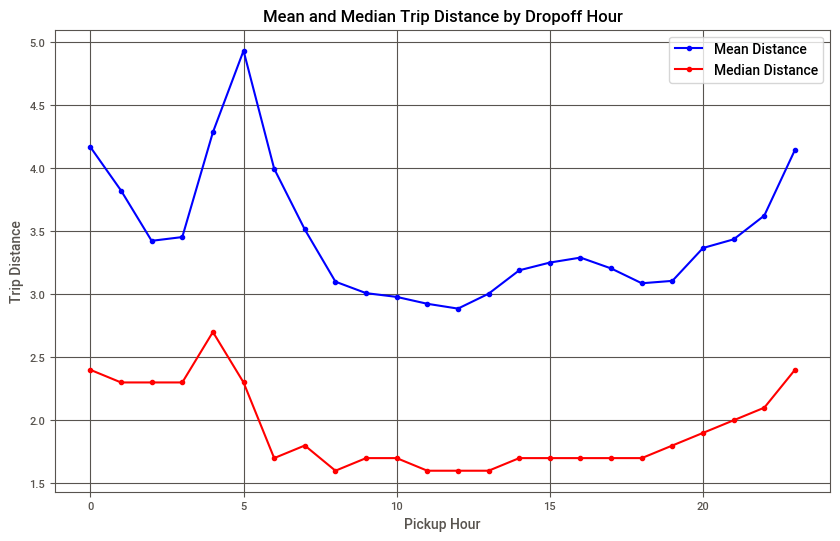

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df with columns 'pickup_datetime' and 'trip_distance'
# Convert 'pickup_datetime' to datetime if it's not already in datetime format
df['pickup_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Extract hour from 'pickup_datetime'
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Group by pickup hour and calculate mean and median trip distances
mean_distance_by_hour = df.groupby('pickup_hour')['trip_distance'].mean()
median_distance_by_hour = df.groupby('pickup_hour')['trip_distance'].median()

# Plotting the line plot for mean trip distances
plt.figure(figsize=(10, 6))
plt.plot(mean_distance_by_hour.index, mean_distance_by_hour, marker='o', color='b', label='Mean Distance')

# Plotting the line plot for median trip distances
plt.plot(median_distance_by_hour.index, median_distance_by_hour, marker='o', color='r', label='Median Distance')

# Adding labels and title
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Distance')
plt.title('Mean and Median Trip Distance by Dropoff Hour')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


### Trips started during 4:00 PM to 6:00 PM tended to be the shortest, and trips started between 4:00 AM and 6:00 AM were the longest. The surge in long-distance trips during the morning is likely driven by trips to the airports or other long-distance rides.

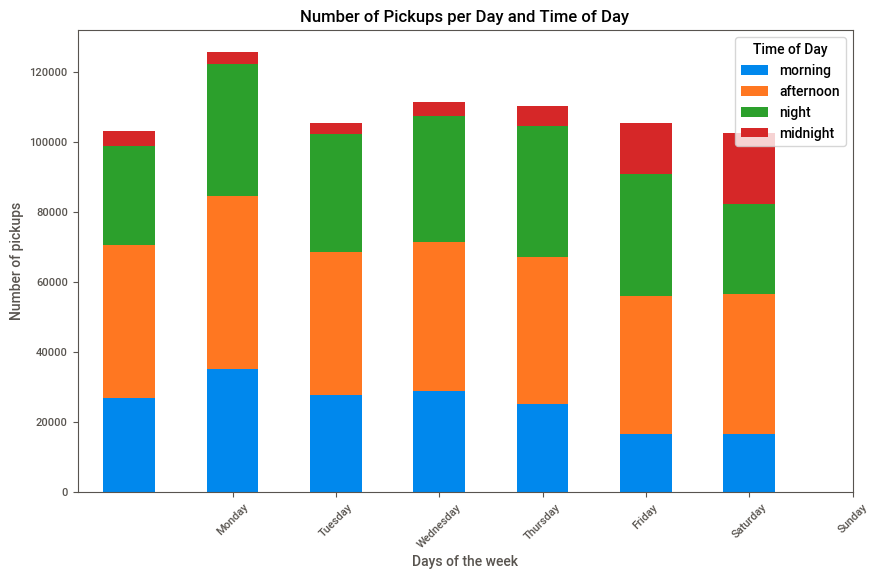

Monday: Morning - 26936, Afternoon - 43489, Night - 28372, Midnight - 4211
Tuesday: Morning - 35222, Afternoon - 49244, Night - 37674, Midnight - 3400
Wednesday: Morning - 27683, Afternoon - 40862, Night - 33638, Midnight - 3280
Thursday: Morning - 28839, Afternoon - 42563, Night - 35852, Midnight - 4145
Friday: Morning - 25255, Afternoon - 41977, Night - 37358, Midnight - 5611
Saturday: Morning - 16654, Afternoon - 39220, Night - 35004, Midnight - 14455
Sunday: Morning - 16635, Afternoon - 40045, Night - 25650, Midnight - 20260


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,day,pickup_datetime,pickup_hour,pickup_day
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.9,1.0,138,7,1,12.1,7.25,...,0.00,0.00,1.0,20.85,0.0,1.25,1,2023-01-01 00:13:25,0,7
11,2023-01-01 00:43:37,2023-01-01 01:17:18,4.0,7.3,1.0,79,264,1,33.8,3.50,...,7.75,0.00,1.0,46.55,2.5,0.00,1,2023-01-01 01:17:18,0,7
17,2023-01-01 00:04:33,2023-01-01 00:19:22,1.0,4.5,1.0,113,255,1,20.5,3.50,...,4.00,0.00,1.0,29.50,2.5,0.00,1,2023-01-01 00:19:22,0,7
18,2023-01-01 00:03:36,2023-01-01 00:09:36,3.0,1.2,1.0,237,239,2,8.6,3.50,...,0.00,0.00,1.0,13.60,2.5,0.00,1,2023-01-01 00:09:36,0,7
19,2023-01-01 00:15:23,2023-01-01 00:29:41,2.0,2.5,1.0,143,229,2,15.6,3.50,...,0.00,0.00,1.0,20.60,2.5,0.00,1,2023-01-01 00:29:41,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995011,2023-01-31 23:33:00,2023-01-31 23:42:16,1.0,5.4,1.0,138,226,1,22.6,7.25,...,6.25,0.00,1.0,37.60,0.0,1.25,31,2023-01-31 23:42:16,23,2
2995012,2023-01-31 23:05:28,2023-01-31 23:35:30,1.0,13.9,1.0,132,91,1,54.1,2.25,...,10.00,0.00,1.0,67.85,0.0,1.25,31,2023-01-31 23:35:30,23,2
2995016,2023-01-31 23:19:24,2023-01-31 23:32:07,1.0,7.4,1.0,138,75,1,29.6,7.25,...,8.95,6.55,1.0,53.85,0.0,1.25,31,2023-01-31 23:32:07,23,2
2995018,2023-01-31 23:00:19,2023-02-01 00:08:33,1.0,13.9,99.0,228,159,1,50.5,0.00,...,0.00,0.00,1.0,52.00,0.0,0.00,31,2023-02-01 00:08:33,23,2


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_pickups_per_day(df):
    # Convert pickup datetime to datetime type
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    
    # Extract day of the week and hour
    df["pickup_day"] = df['tpep_pickup_datetime'].dt.strftime('%u').astype(int)
    df["pickup_hour"] = df['tpep_pickup_datetime'].dt.hour
    
    # Calculate pickups for different time periods
    day_pickups = df[(df.pickup_hour >= 6) & (df.pickup_hour < 12)].groupby('pickup_day').size()
    afternoon_pickups = df[(df.pickup_hour >= 12) & (df.pickup_hour < 18)].groupby('pickup_day').size()
    night_pickups = df[(df.pickup_hour >= 18) & (df.pickup_hour <= 23)].groupby('pickup_day').size()
    mid_night_pickups = df[(df.pickup_hour >= 0) & (df.pickup_hour < 6)].groupby('pickup_day').size()
    
    # Concatenate pickup counts into DataFrame
    days = pd.DataFrame({'morning': day_pickups, 'afternoon': afternoon_pickups, 
                         'night': night_pickups, 'midnight': mid_night_pickups})
    
    # Plotting
    days.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.xlabel('Days of the week')
    plt.ylabel('Number of pickups')
    plt.xticks(range(1, 8), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
    plt.legend(title='Time of Day')
    plt.title('Number of Pickups per Day and Time of Day')
    plt.show()
    
    # Print pickup counts
    days.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for day, pickups in days.iterrows():
        print(f"{day}: Morning - {pickups['morning']}, Afternoon - {pickups['afternoon']}, Night - {pickups['night']}, Midnight - {pickups['midnight']}")
    
    return df
# Assuming df is your DataFrame
# Call the function
compute_pickups_per_day(df)


#### We get most no. of pickups during daytime and lowest during midnight for all the days of the week

In [32]:
import pulp
import pandas as pd
df_ = df[df['tpep_pickup_datetime'].dt.day == 1]
# Sample DataFrame `df` containing necessary data
# Replace this with your actual DataFrame
# df = pd.read_csv("your_data.csv")

# Extract unique pickup and dropoff locations
locations = sorted(set(df_['PULocationID']).union(set(df_['DOLocationID'])))

# Define decision variables
x = pulp.LpVariable.dicts("Trip", [(i, j) for i in locations for j in locations], cat=pulp.LpBinary)

# Define profit associated with each trip based on fare amount
trip_profit = {(i, j): df_.loc[(df_['PULocationID'] == i) & (df_['DOLocationID'] == j), 'fare_amount'].sum() for i in locations for j in locations}

# Initialize optimization problem
prob = pulp.LpProblem("Taxi Route Optimization", pulp.LpMaximize)

# Define objective function (maximize total profit)
prob += pulp.lpSum(x[(i, j)] * trip_profit[(i, j)] for i in locations for j in locations)

# Define constraints
# Ensure that the taxi moves consecutively from one station to the next
for i in locations:
    for j in locations:
        if i != j:
            prob += x[(i, j)] <= x[(i, i)]  # Taxi moves from i to j only if it's at station i

# Solve the linear program
prob.solve()

# Extract the optimal route
optimal_route = [(i, j) for i in locations for j in locations if pulp.value(x[(i, j)]) == 1]

# Print the optimal route and associated profit
total_profit = sum(trip_profit[trip] for trip in optimal_route)

print("Total Profit:", total_profit)


Total Profit: 355111.2600000005


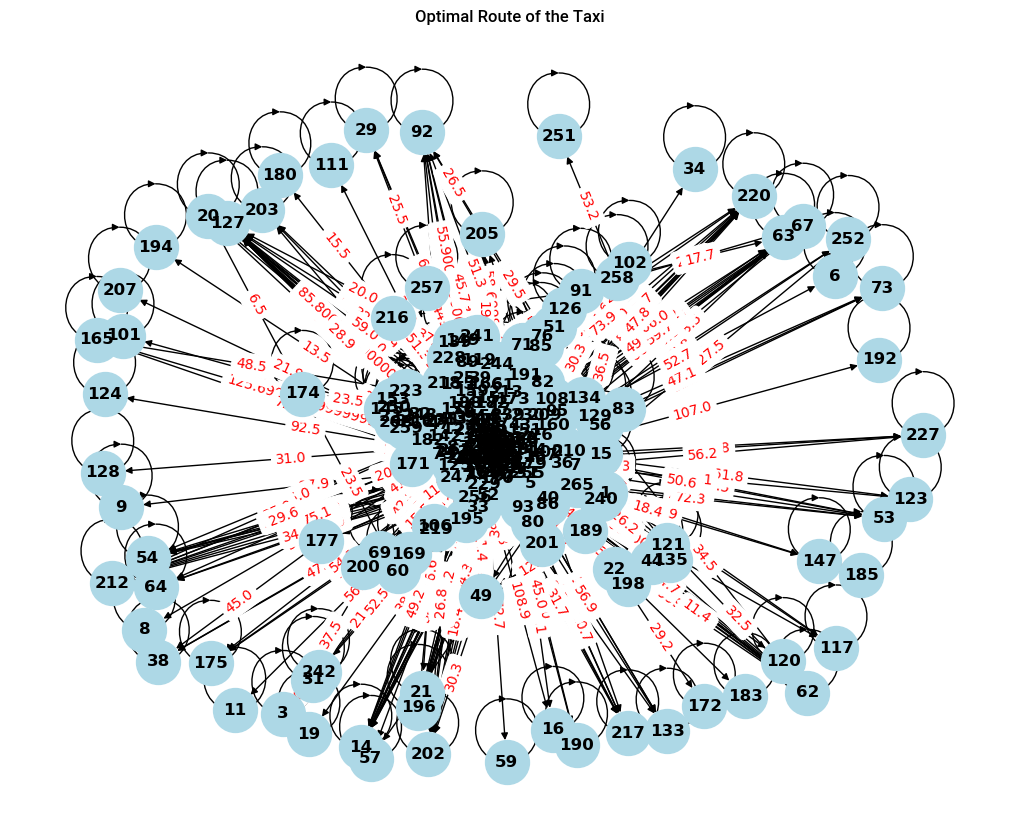

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

# Sample DataFrame `df` containing necessary data
# Replace this with your actual DataFrame
# df = pd.read_csv("your_data.csv")

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each unique location
for location in locations:
    G.add_node(location)

# Add edges for each trip in the optimal route
for i, j in optimal_route:
    G.add_edge(i, j)

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=12, font_weight='bold', arrows=True)
edge_labels = {(i, j): trip_profit[(i, j)] for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10, label_pos=0.5)
plt.title("Optimal Route of the Taxi")
plt.show()


In [34]:
import pandas as pd

# Step 1: Filter the dataset for the specific date
specific_date = "2023-01-01"  # Change this to your desired date
df_specific_date = df[df['pickup_datetime'].dt.date == pd.to_datetime(specific_date).date()]

# Step 2: Group the data by pickup and dropoff locations to find the total fare for each route
route_fares = df_specific_date.groupby(['PULocationID', 'DOLocationID'])['fare_amount'].sum().reset_index()

# Step 3: Identify the route with the maximum total fare
max_fare_route = route_fares.loc[route_fares['fare_amount'].idxmax()]

# Print the details of the best route
print("Best Route Details for", specific_date)
print("Pickup Location:", max_fare_route['PULocationID'])
print("Dropoff Location:", max_fare_route['DOLocationID'])
print("Total Fare Amount:", max_fare_route['fare_amount'])


Best Route Details for 2023-01-01
Pickup Location: 132.0
Dropoff Location: 265.0
Total Fare Amount: 2837.8


## PULocationID and DULocationID

In [35]:
df['PULocationID'].nunique() # no of stations

248

In [36]:
dist = df[['PULocationID','DOLocationID','trip_distance']]
dist = dist[dist['PULocationID'] != dist['DOLocationID']]

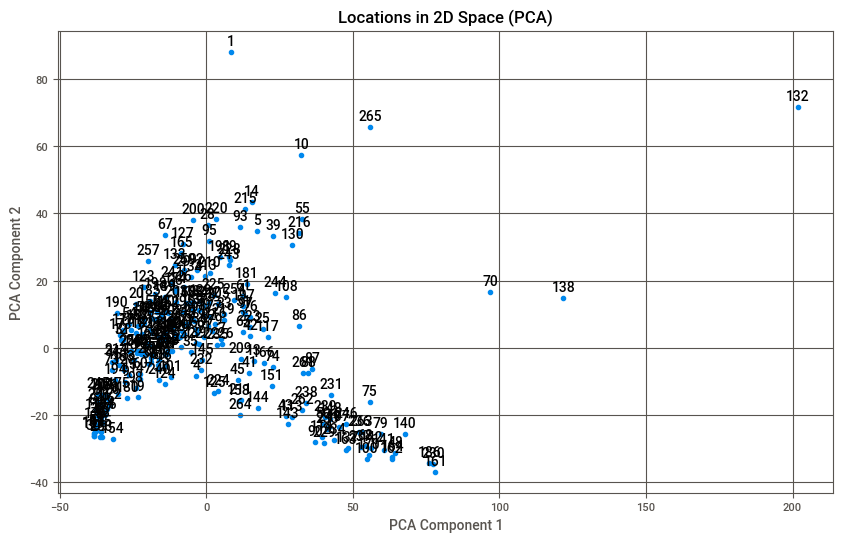

In [37]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Get unique location IDs
location_ids = np.unique(dist[['PULocationID', 'DOLocationID']])

# Create a distance matrix
distance_matrix = np.zeros((len(location_ids), len(location_ids)))

for _, row in dist.iterrows():
    i = np.where(location_ids == row['PULocationID'])[0][0]
    j = np.where(location_ids == row['DOLocationID'])[0][0]
    distance_matrix[i, j] = row['trip_distance']
    distance_matrix[j, i] = row['trip_distance']

# Perform PCA
pca = PCA(n_components=2)
coordinates = pca.fit_transform(distance_matrix)

# Plot the locations in 2D
plt.figure(figsize=(10, 6))
plt.scatter(coordinates[:, 0], coordinates[:, 1])

# Annotate the locations with their IDs
for i, location_id in enumerate(location_ids):
    plt.annotate(location_id, (coordinates[i, 0], coordinates[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')
 
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Locations in 2D Space (PCA)')
plt.grid(True)
plt.show()


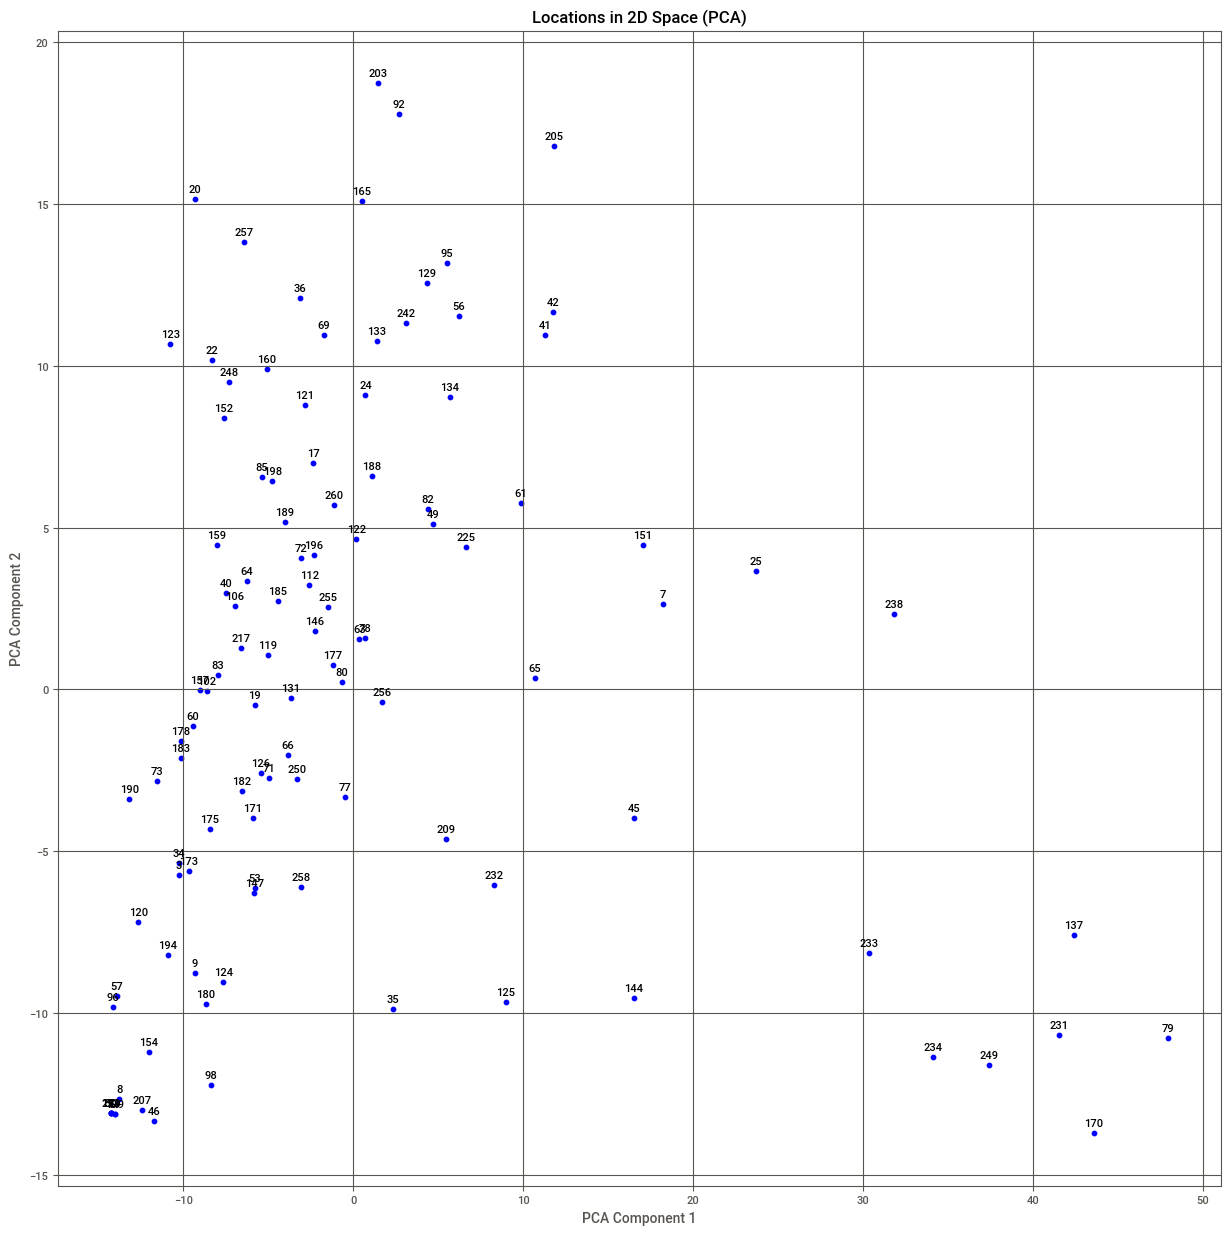

In [38]:

# Get unique location IDs
location_ids = np.unique(dist[['PULocationID', 'DOLocationID']])

# Create a distance matrix
distance_matrix = np.zeros((len(location_ids), len(location_ids)))

for _, row in dist.iterrows():
    i = np.where(location_ids == row['PULocationID'])[0][0]
    j = np.where(location_ids == row['DOLocationID'])[0][0]
    distance_matrix[i, j] = row['trip_distance']
    distance_matrix[j, i] = row['trip_distance']

# Calculate distances to remove outliers
median_distance = np.median(distance_matrix[distance_matrix > 0])
threshold = median_distance * 3  # You can adjust this threshold as needed

# Filter out points that are too far away
mask = np.max(distance_matrix, axis=1) < threshold
location_ids = location_ids[mask]
distance_matrix = distance_matrix[mask][:, mask]

# Perform PCA
pca = PCA(n_components=2)
coordinates = pca.fit_transform(distance_matrix)

# Plot the locations in 2D
plt.figure(figsize=(15, 15))
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=10, color='blue')

# Annotate the locations with their IDs
for i, location_id in enumerate(location_ids):
    plt.annotate(location_id, (coordinates[i, 0], coordinates[i, 1]), fontsize=8, textcoords="offset points", xytext=(0, 5), ha='center')  # smaller font size


plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Locations in 2D Space (PCA)')
plt.grid(True)
plt.show()

In [39]:
## now try to fit a model between these

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming you have your data loaded into a DataFrame called 'df'
# 'PULocationID' as feature and 'DOLocationID' as target

# Separate features (X) and target variable (y)
X = df[['PULocationID']]
y = df['DOLocationID']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Optionally, you can fit the best model on the entire dataset
# model.fit(X, y)


Mean Squared Error: 4844.825135028637


In [41]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit the random forest regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_rf = rf_model.predict(X_test)

# Calculate Mean Squared Error
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Mean Squared Error:", mse_rf)


Random Forest Mean Squared Error: 4729.128609465328


## Time , Distance , Fare Amount

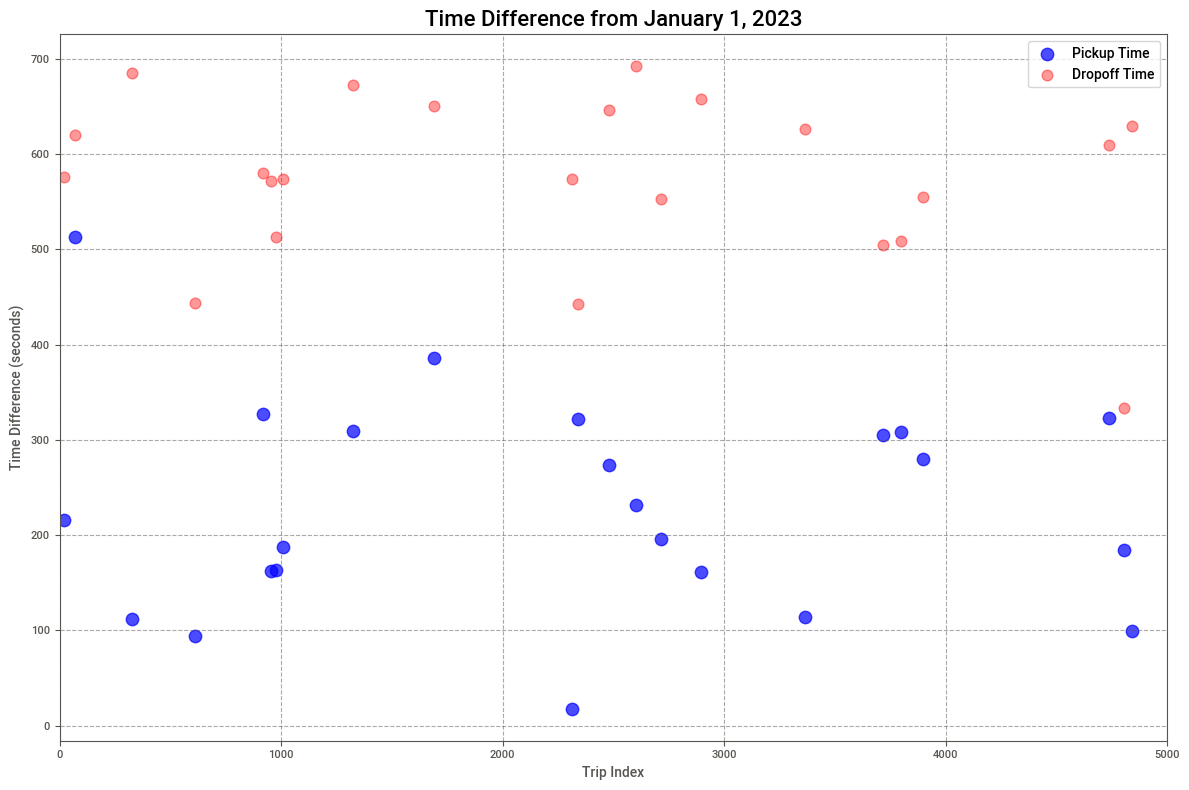

In [42]:
df_c = df
df_c = df_c[df_c['tpep_dropoff_datetime'].dt.day==1]
df_c =df_c[df_c['tpep_dropoff_datetime'].dt.month ==1]
df_c['tpep_pickup_datetime'] = (df_c['tpep_pickup_datetime'] - pd.to_datetime('2023-01-01')).dt.total_seconds()
df_c['tpep_dropoff_datetime'] = (df_c['tpep_dropoff_datetime'] - pd.to_datetime('2023-01-01')).dt.total_seconds()
df_c = df_c[df_c['tpep_dropoff_datetime'] <= 700] # 700 is for to reduce the points to visualise it clearly
df_c = df_c.sort_values(by='tpep_pickup_datetime')

# Assuming your data is stored in a DataFrame called df_c
plt.figure(figsize=(12, 8))

# Plot pickup time difference
plt.scatter(df_c.index, df_c['tpep_pickup_datetime'], label='Pickup Time', color='blue', alpha=0.7, s=80)
plt.scatter(df_c.index, df_c['tpep_dropoff_datetime'], label='Dropoff Time', color='red', alpha=0.4, s=60)

plt.xlabel('Trip Index')
plt.ylabel('Time Difference (seconds)')
plt.title('Time Difference from January 1, 2023', fontsize=16)
plt.xlim(0, 5000)

# Add grid
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend()

# Tight layout
plt.tight_layout()

# Show plot
plt.show()

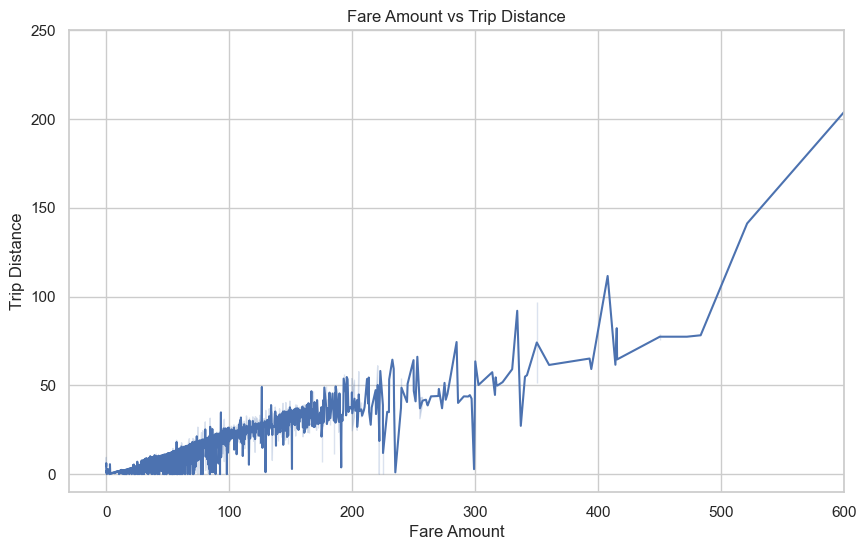

In [43]:
# Set style
sns.set(style="whitegrid")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='fare_amount', y='trip_distance', data=df)

# Add labels and title
plt.title('Fare Amount vs Trip Distance')
plt.xlabel('Fare Amount')
plt.ylabel('Trip Distance')

# Set x-axis limit to zoom to 1200 trip distance
plt.xlim(right=600)
plt.ylim(top=250)
# Show plot
plt.show()

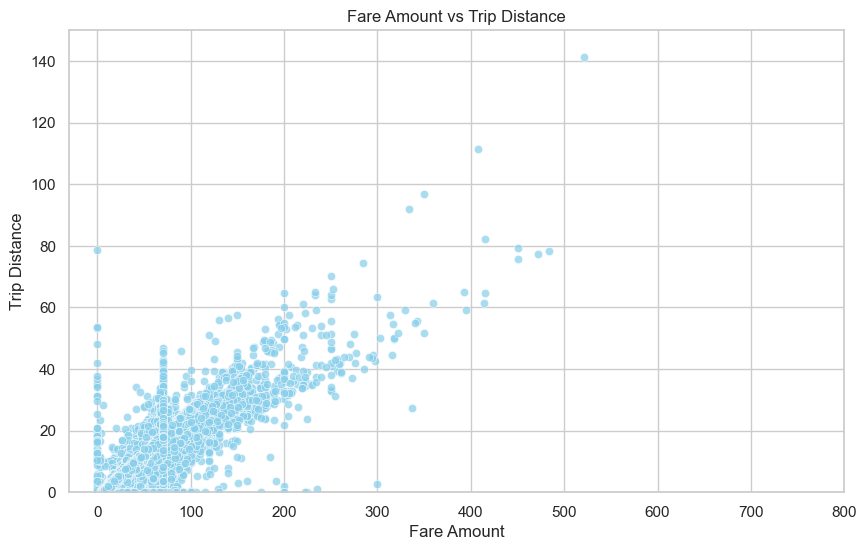

In [44]:

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='trip_distance', data=df, color='skyblue', alpha=0.7)

# Add labels and title
plt.title('Fare Amount vs Trip Distance')
plt.xlabel('Fare Amount')
plt.ylabel('Trip Distance')

# Set x-axis limit to zoom to 1200 trip distance
plt.xlim(right=800)

# Set y-axis limit to zoom to 0 to 150 trip distance
plt.ylim(0, 150)

# Show plot
plt.show()

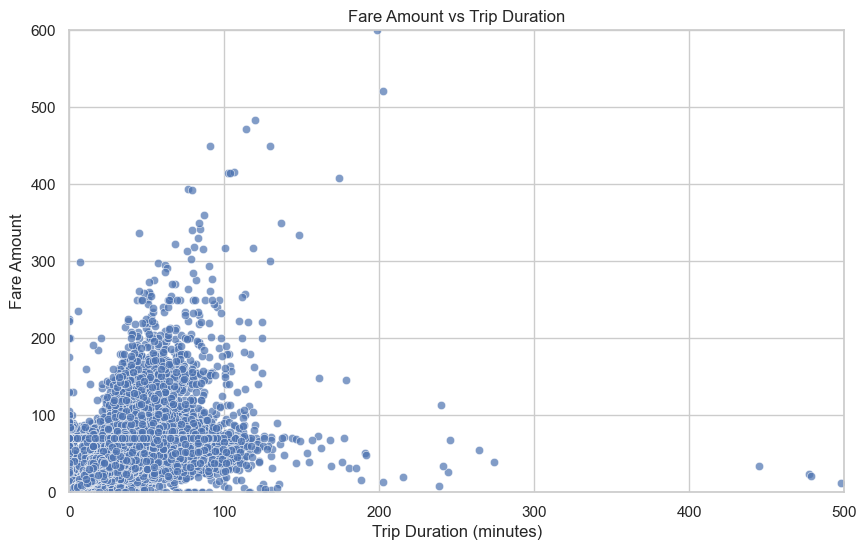

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the time duration of the trip in minutes
time = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=time, y=df['fare_amount'], alpha=0.7)

# Add labels and title
plt.title('Fare Amount vs Trip Duration')
plt.ylabel('Fare Amount')
plt.xlabel('Trip Duration (minutes)')

# Set axis limits
plt.ylim(0, 600)  
plt.xlim(0, 500)   

# Show plot
plt.show()


C:\Users\indra\AppData\Local\Temp\ipykernel_10876\3384825460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Jan_1['tpep_pickup_datetime'] = pd.to_datetime(Jan_1['tpep_pickup_datetime'])


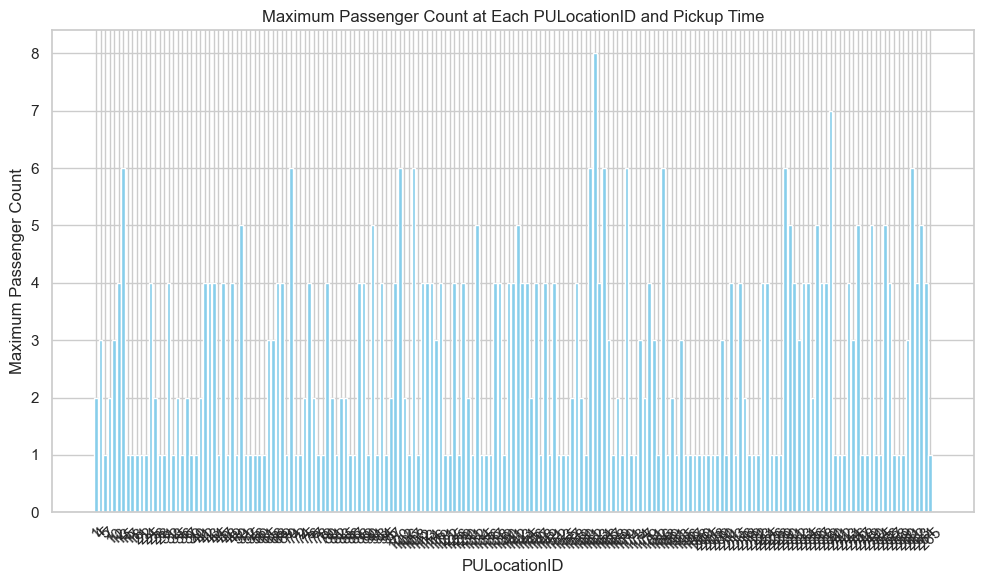

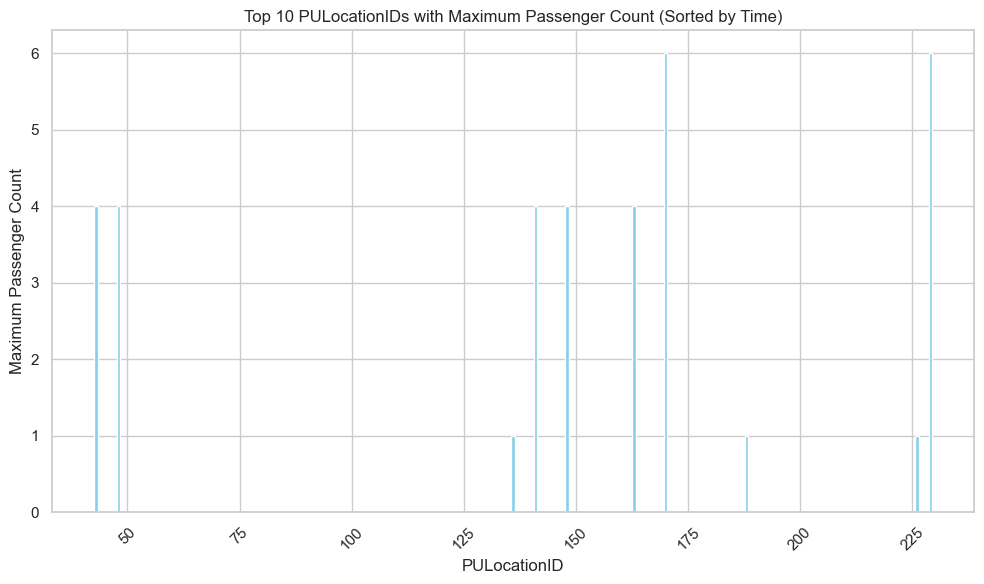

In [48]:
Jan_1 = df[df['tpep_pickup_datetime'].dt.day == 1]

# Convert pickup datetime to datetime type if it's not already
Jan_1['tpep_pickup_datetime'] = pd.to_datetime(Jan_1['tpep_pickup_datetime'])

# Grouping by PULocationID and pickup time, then summing passenger counts
passenger_counts_by_location_time = Jan_1.groupby(['PULocationID', Jan_1['tpep_pickup_datetime'].dt.time])['passenger_count'].sum()

# Finding the pickup time with the maximum total passengers for each PULocationID
max_passenger_times = passenger_counts_by_location_time.groupby('PULocationID').idxmax()
max_passenger_counts = passenger_counts_by_location_time.groupby('PULocationID').max()

# Extracting pickup times and counts
pickup_times = [time[1] for time in max_passenger_times]
passenger_counts = max_passenger_counts.values

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(range(len(pickup_times)), passenger_counts, color='skyblue')
plt.xlabel('PULocationID')
plt.ylabel('Maximum Passenger Count')
plt.title('Maximum Passenger Count at Each PULocationID and Pickup Time')
plt.xticks(range(len(pickup_times)), max_passenger_counts.index, rotation=45)
plt.tight_layout()






# Sort the locations by pickup time
sorted_locations = sorted(max_passenger_times.items(), key=lambda x: x[1][1])


# Visualize the first n results
n = 10  # You can change this value to visualize more or fewer results

# Extract top n locations and their corresponding passenger counts and pickup times
top_n_locations = [location_id for location_id, _ in sorted_locations[:n]]
top_n_counts = [max_passenger_counts[location_id] for location_id in top_n_locations]
top_n_pickup_times = [pickup_time[1] for location_id, pickup_time in sorted_locations[:n]]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(top_n_locations, top_n_counts, color='skyblue')
plt.xlabel('PULocationID')
plt.ylabel('Maximum Passenger Count')
plt.title(f'Top {n} PULocationIDs with Maximum Passenger Count (Sorted by Time)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


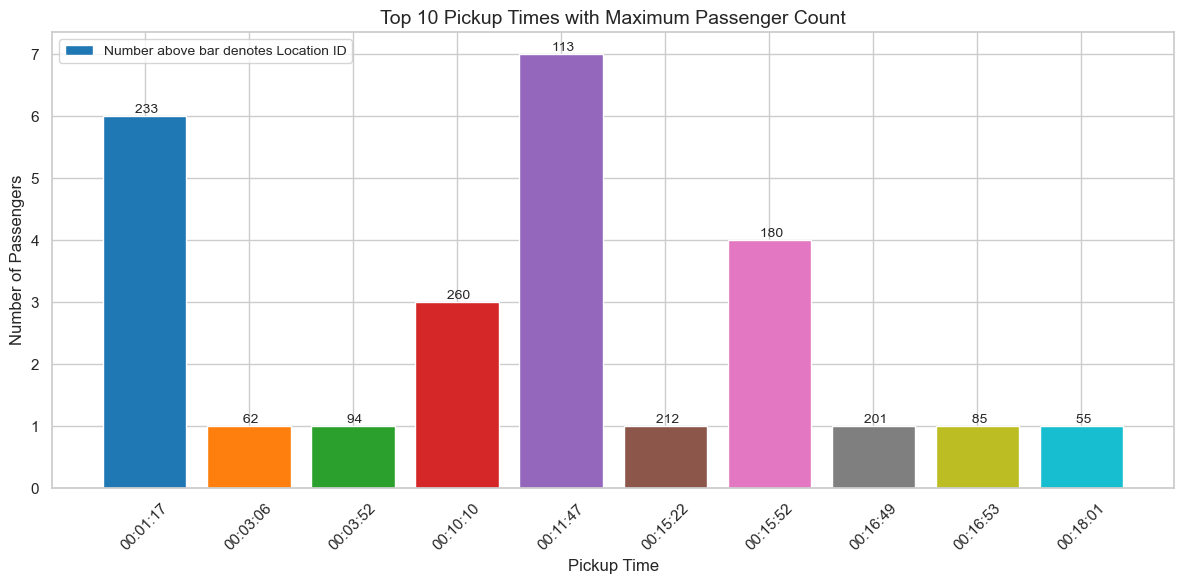

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named df

# Convert pickup datetime to datetime type if it's not already
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Grouping by PULocationID and pickup time, then summing passenger counts
passenger_counts_by_location_time = df.groupby(['PULocationID', df['tpep_pickup_datetime'].dt.time])['passenger_count'].sum()

# Finding the pickup time with the maximum total passengers for each PULocationID
max_passenger_times = passenger_counts_by_location_time.groupby('PULocationID').idxmax()
max_passenger_counts = passenger_counts_by_location_time.groupby('PULocationID').max()

# Sort the locations by pickup time
sorted_locations = sorted(max_passenger_times.items(), key=lambda x: x[1][1])

# Visualize the first n results
n = 10  # You can change this value to visualize more or fewer results

# Extract top n locations and their corresponding passenger counts and pickup times
top_n_locations = [location_id for location_id, _ in sorted_locations[:n]]
top_n_counts = [max_passenger_counts[location_id] for location_id in top_n_locations]
top_n_pickup_times = [pickup_time[1] for location_id, pickup_time in sorted_locations[:n]]

# Define custom colors for bars
colors = plt.cm.tab10.colors[:n]

# Plotting the results
plt.figure(figsize=(12, 6))
bars = plt.bar(range(n), top_n_counts, color=colors)

legend_labels = ['Number above bar denotes Location ID']
plt.legend( legend_labels, loc='upper left', fontsize=10)

plt.xticks(range(n), top_n_pickup_times, rotation=45)
plt.xlabel('Pickup Time', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.title(f'Top {n} Pickup Times with Maximum Passenger Count', fontsize=14)

# Adding legend to clarify information above each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f' {top_n_locations[i]}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


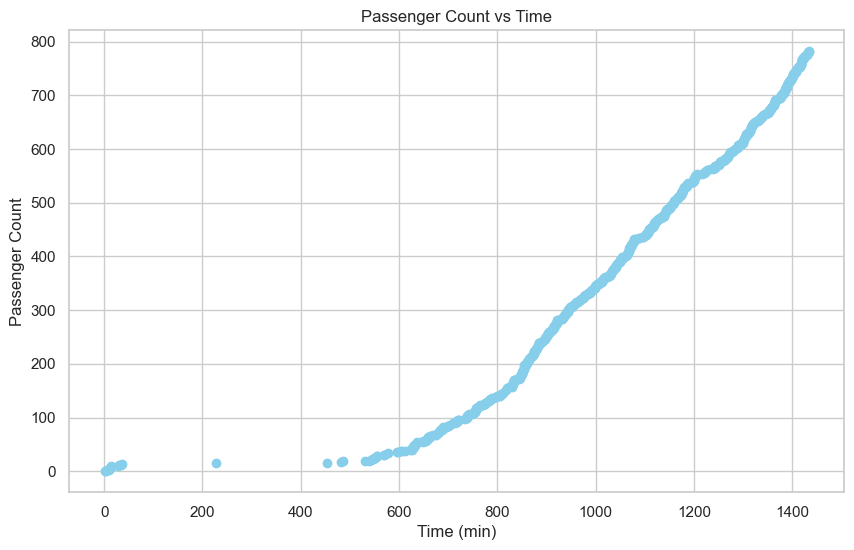

In [50]:
St_1 =  df[df['PULocationID'] == 138]   # at 138 no station
St_1_1 = St_1[St_1['tpep_pickup_datetime'].dt.day == 15][['tpep_pickup_datetime','passenger_count']]
St_1_1['time(min)'] = (St_1_1['tpep_pickup_datetime'] - pd.to_datetime('2023-01-15')).dt.total_seconds()/60
St_1_1.drop('tpep_pickup_datetime', axis=1,inplace=True)
St_1_1 = St_1_1.sort_values(by='time(min)')
St_1_1 = St_1_1.reset_index(drop=True)
st = St_1_1
st['passenger_count'] = st['passenger_count'].cumsum()
# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(st['time(min)'], st['passenger_count'], color='skyblue')
plt.xlabel('Time (min)')
plt.ylabel('Passenger Count')
plt.title('Passenger Count vs Time')
plt.grid(True)
plt.show()

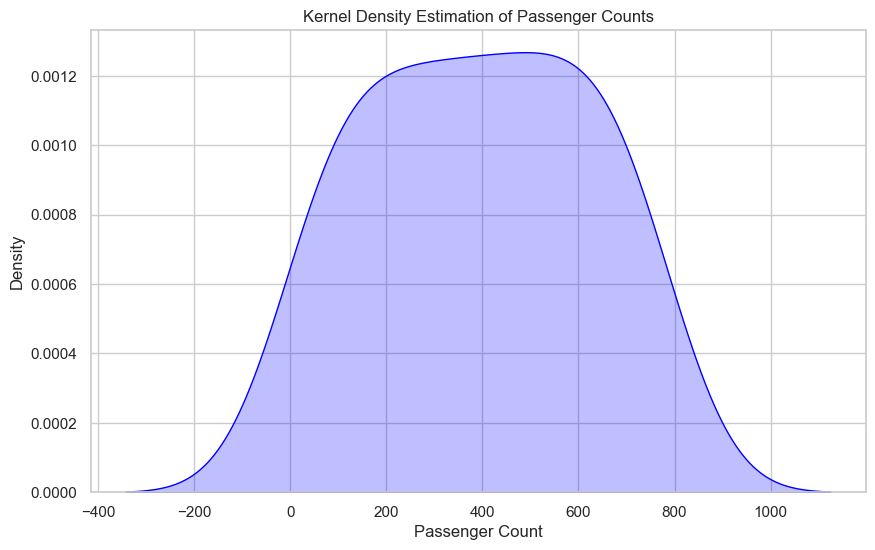

In [51]:

# Plot the KDE of passenger counts
plt.figure(figsize=(10, 6))
sns.kdeplot(St_1_1['passenger_count'], bw_method=0.5, color='blue', fill=True)

plt.title('Kernel Density Estimation of Passenger Counts')
plt.xlabel('Passenger Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()

### this can be seen as uniformly distributed

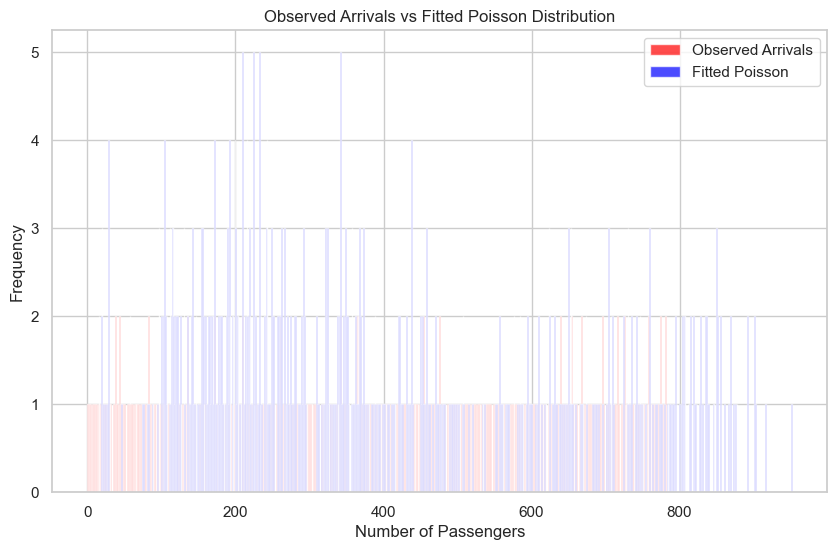

In [52]:
## now appling possion process
# Fit Poisson regression model
X = sm.add_constant(St_1_1['time(min)'])  # Add constant for intercept
y = St_1_1['passenger_count']
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Calculate the observed counts
observed_counts = y

# Calculate the fitted Poisson distribution
lambda_estimate = poisson_model.predict(X)
fitted_poisson = np.random.poisson(lambda_estimate)

# Plot histogram of observed arrivals
plt.figure(figsize=(10, 6))
plt.hist(observed_counts, bins=range(int(observed_counts.min()), int(observed_counts.max()) + 1), alpha=0.7, label='Observed Arrivals', color='red')

# Plot fitted Poisson distribution
plt.hist(fitted_poisson, bins=range(int(fitted_poisson.min()), int(fitted_poisson.max()) + 1), alpha=0.7, label='Fitted Poisson', color='blue')

plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.title('Observed Arrivals vs Fitted Poisson Distribution')
plt.legend()
plt.grid(True)
plt.show()

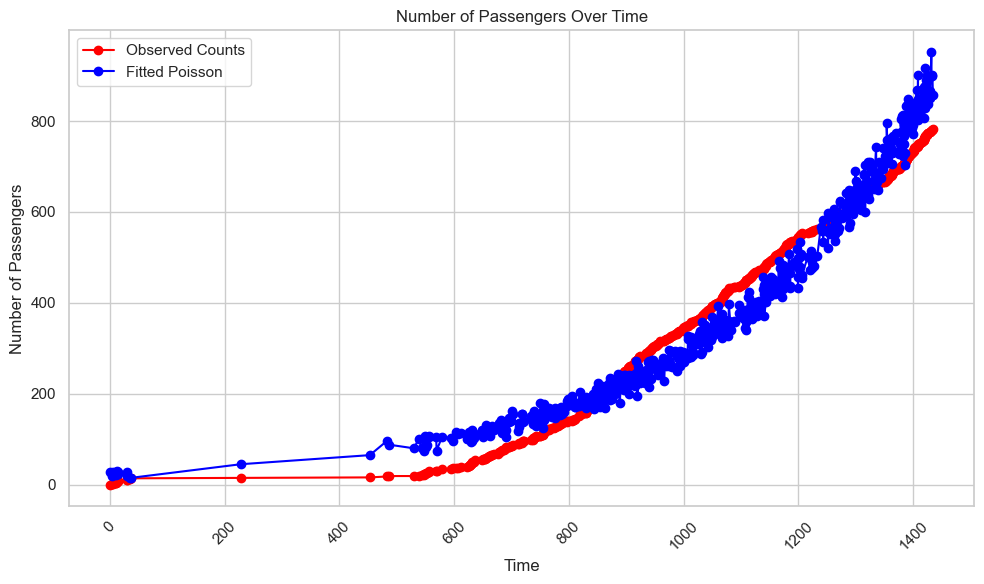

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(St_1_1['time(min)'], St_1_1['passenger_count'], marker='o', linestyle='-', color='red', label='Observed Counts')
plt.plot(St_1_1['time(min)'], fitted_poisson, marker='o', linestyle='-', color='blue', label='Fitted Poisson')
plt.title('Number of Passengers Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Now using records for continous time and discrete statespace stocastic process


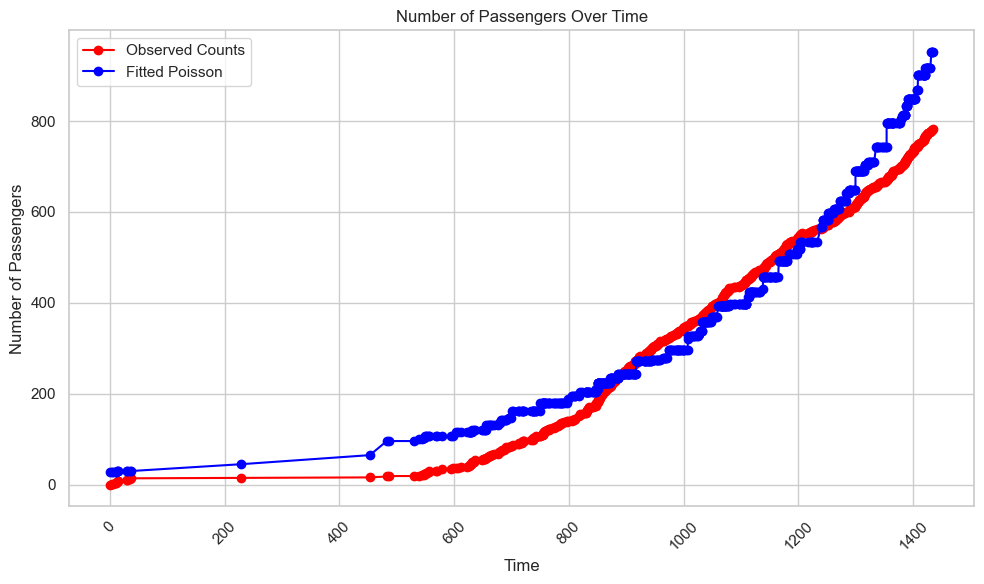

In [54]:
for i in range(1,len(fitted_poisson)):
    fitted_poisson[i] = np.maximum(fitted_poisson[i-1] , fitted_poisson[i])
plt.figure(figsize=(10, 6))
plt.plot(St_1_1['time(min)'], St_1_1['passenger_count'], marker='o', linestyle='-', color='red', label='Observed Counts')
plt.plot(St_1_1['time(min)'], fitted_poisson, marker='o', linestyle='-', color='blue', label='Fitted Poisson')
plt.title('Number of Passengers Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


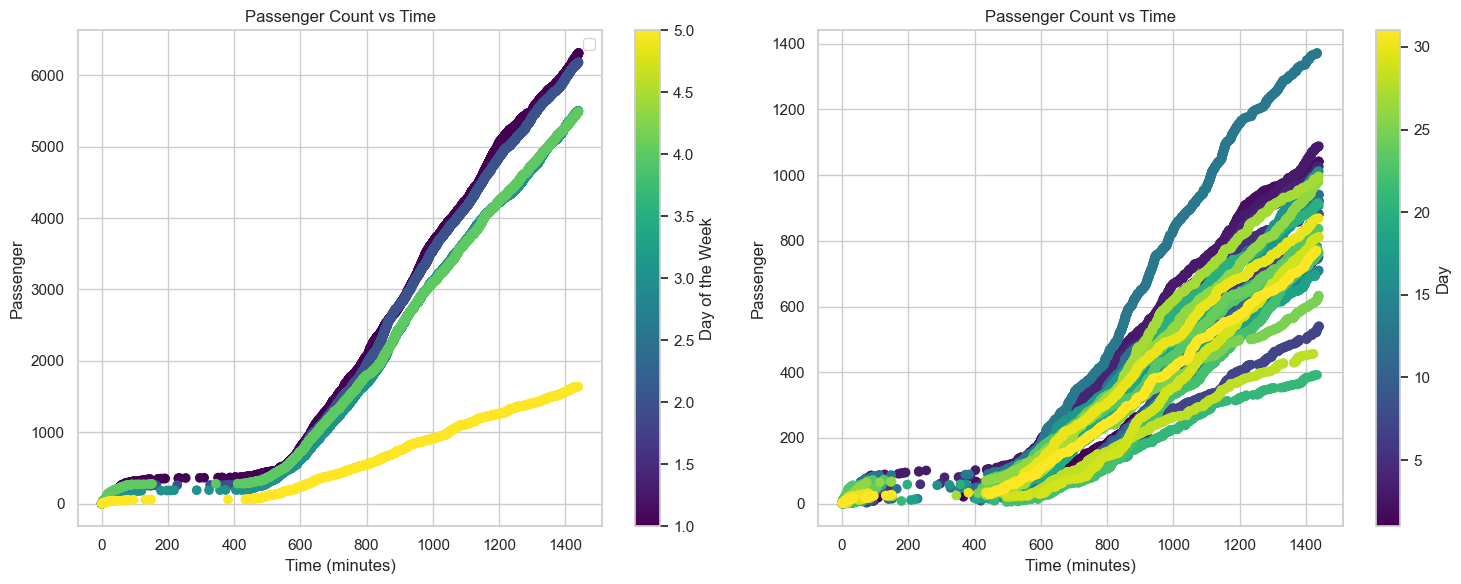

In [55]:
# visualising this with respect to weeks
df_1 = df[df['PULocationID']==138]
time= df_1['tpep_pickup_datetime'].dt.time
time = pd.to_datetime(time, format='%H:%M:%S')
time = (time - pd.to_datetime(time.dt.date.iloc[0])).dt.total_seconds()/60
day = df_1['tpep_pickup_datetime'].dt.day
pass_cnt = df_1['passenger_count']
st_138 = pd.DataFrame({'Day':day,'Time(min)':time,'Passenger':pass_cnt})
st_138 = st_138.sort_values(by=['Day', 'Time(min)'])
st_138['pass_cnt'] =st_138.groupby('Day')['Passenger'].cumsum()
timea= df_1['tpep_pickup_datetime'].dt.time
timea = pd.to_datetime(timea, format='%H:%M:%S')
timea = (timea - pd.to_datetime(timea.dt.date.iloc[0])).dt.total_seconds()/60
daya = pd.to_datetime( df_1['tpep_pickup_datetime'])
daya = daya.dt.isocalendar().week
pass_cnta = df_1['passenger_count']
st_138a = pd.DataFrame({'Day':daya,'Time(min)':timea,'Passenger':pass_cnta})
st_138a = st_138a.sort_values(by=['Day', 'Time(min)'])
st_138a['pass_cnt'] =st_138a.groupby('Day')['Passenger'].cumsum()
st_138a = st_138a[st_138a['Day'] != 52]


# Create side-by-side plots
plt.figure(figsize=(15, 6))

# Plot 1
plt.subplot(1, 2, 1)

plt.scatter(st_138a['Time(min)'], st_138a['pass_cnt'], c=st_138a['Day'], cmap='viridis')
plt.xlabel('Time (minutes)')
plt.ylabel('Passenger')
plt.title('Passenger Count vs Time')
plt.colorbar(label='Day of the Week')
plt.legend()

# Plot 2
plt.subplot(1, 2, 2)
plt.scatter(st_138['Time(min)'], st_138['pass_cnt'], c=st_138['Day'], cmap='viridis')
plt.xlabel('Time (minutes)')
plt.ylabel('Passenger')
plt.title('Passenger Count vs Time')
plt.colorbar(label='Day')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


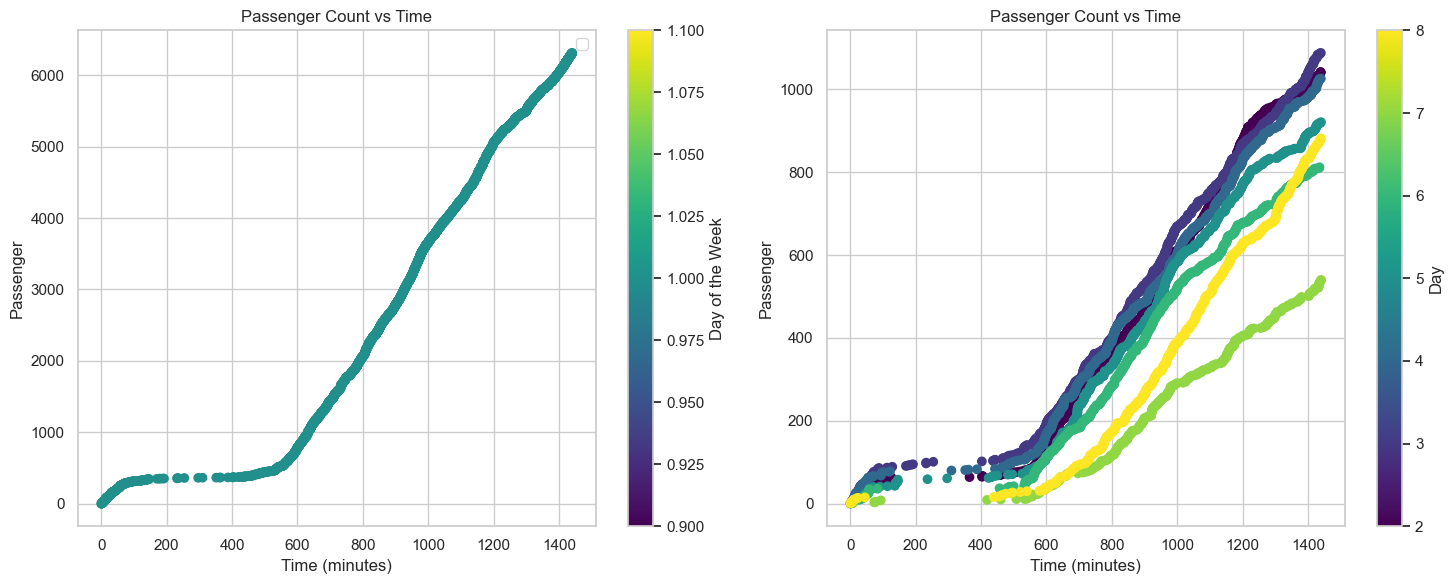

In [56]:
daya = pd.to_datetime( df_1['tpep_pickup_datetime'])
daya = daya.dt.isocalendar().week
daya = daya[daya==1]
pass_cnta = df_1['passenger_count']
st_138a = pd.DataFrame({'Day':daya,'Time(min)':timea,'Passenger':pass_cnta})
st_138a = st_138a.sort_values(by=['Day', 'Time(min)'])
st_138a['pass_cnt'] =st_138a.groupby('Day')['Passenger'].cumsum()
st_138a = st_138a[st_138a['Day'] != 52]
st_138a.head()

# Create side-by-side plots
plt.figure(figsize=(15, 6))

# Plot 1
plt.subplot(1, 2, 1)

plt.scatter(st_138a['Time(min)'], st_138a['pass_cnt'], c=st_138a['Day'], cmap='viridis')
plt.xlabel('Time (minutes)')
plt.ylabel('Passenger')
plt.title('Passenger Count vs Time')
plt.colorbar(label='Day of the Week')
plt.legend()



st_138 = st_138[(st_138['Day'] >= 2) & (st_138['Day'] <= 8)]
# Plot 2
plt.subplot(1, 2, 2)
plt.scatter(st_138['Time(min)'], st_138['pass_cnt'], c=st_138['Day'], cmap='viridis')
plt.xlabel('Time (minutes)')
plt.ylabel('Passenger')
plt.title('Passenger Count vs Time')
plt.colorbar(label='Day')

plt.tight_layout()
plt.show()


#### by above plot we can see that weekly assumbtion will not be as correct as daily will be

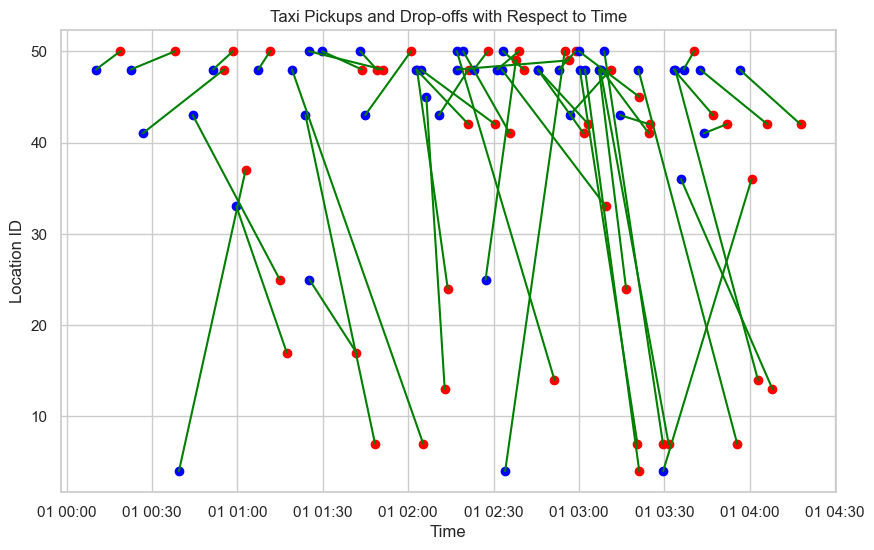

In [57]:
# pickup and dropoff wrt time

# Load your data
taxi_data = df[(df['PULocationID']>=0) &(df['PULocationID'] <=50) & (df['DOLocationID'] >= 0) & (df['DOLocationID'] <=50)] 
taxi_data =taxi_data[taxi_data['tpep_pickup_datetime'].dt.day == 1]
taxi_data = taxi_data.iloc[range(0,50)] 

# Convert pickup and dropoff timestamps to datetime objects
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each row in the DataFrame
for index, row in taxi_data.iterrows():
    # Plot pickup location with specific time
    ax.scatter(row['tpep_pickup_datetime'], row['PULocationID'], color='blue')
    
    # Plot dropoff location with specific time
    ax.scatter(row['tpep_dropoff_datetime'], row['DOLocationID'], color='red')
    
    # Draw a line connecting pickup and dropoff locations
    ax.plot([row['tpep_pickup_datetime'], row['tpep_dropoff_datetime']], [row['PULocationID'], row['DOLocationID']], color='green')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Location ID')
ax.set_title('Taxi Pickups and Drop-offs with Respect to Time')

# Show plot
plt.show()


## Simulation 

In [58]:
def passanger(da, station, tim):
    data = df[(df['PULocationID'] == station) & (df['day'] == da)]
    
    if data.empty:
        # If there are no records for this date and station, return 0 passengers
        return 0
    
    data['time'] = (data['tpep_pickup_datetime'] - pd.to_datetime(f'2023-01-{da}')).dt.total_seconds() / 60
    data = data.sort_values('time')
    
    X = data['time'].values.reshape(-1, 1)  # Reshape X for model fitting
    y = data['passenger_count'].values
    
    if len(X) == 0 or len(y) == 0:
        # If X or y is empty, return 0 passengers
        return 0
    
    # Check for zeros or missing values in X
    if np.any(X == 0) or np.any(np.isnan(X)):
        # If X contains zeros or missing values, return 0 passengers
        return 0
    
    # Fit Poisson regression model
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    
    # Predict passenger count at given time
    lambda_estimate = poisson_model.predict(tim)
    
    # Return the predicted passenger count
    return min(lambda_estimate, 6)  # Cap the prediction at 6 passengers


In [60]:
df['station_time'] = (df['tpep_dropoff_datetime'] -df['tpep_pickup_datetime'])
df['station_time'] = df['station_time'].dt.total_seconds()/60
station = df['PULocationID'].unique()
date = 1 # 1 Jan 2024
tim = 0

import warnings

# Set the warning filter to 'ignore'
warnings.filterwarnings('ignore')

# Create an empty list to store data
Ai = []

# Iterate through each station
for st in station:
    try:
        # Get the number of passengers for the current station
        passengers = passanger(date, st, tim)
        
        # Append station number and number of passengers to the data list
        Ai.append({'station': st, 'passengers': passengers})
    except Exception as e:
        pass  # Skip printing in case of error

# Create a DataFrame from the data list
Ai = pd.DataFrame(Ai)
#Ai['passengers'] = Ai['passengers'].apply(lambda x: int(x[0]))
Ai['passengers'] = Ai['passengers'].apply(lambda x: int(x[0]) if isinstance(x, list) else int(x))
Ai['next'] = Ai['station']
Ai['time'] = Ai['station']
Ai['distance'] = Ai['station']
next_trip = df[['PULocationID','DOLocationID','station_time','trip_distance']]

next_trip = next_trip.reset_index(drop=True)
row = 0
for sta in Ai['station']:
    no = next_trip[next_trip['PULocationID'] == sta]
    no = no.sample(n=1) 
    Ai['next'].iloc[row] = no['DOLocationID']
    Ai['time'].iloc[row] = no['station_time']
    Ai['distance'].iloc[row] = no['trip_distance']
    row += 1

Ai

,station,passengers,next,time,distance
0,138,1,25,35.633333,10.7
1,79,1,137,6.033333,1.3
2,113,1,41,31.316667,8.6
3,237,1,161,9.716667,1.3
4,143,1,161,9.800000,1.5
...,...,...,...,...,...
210,54,0,164,20.383333,7.0
211,253,0,31,28.866667,8.1
212,57,0,95,7.350000,2.7
213,115,0,215,38.733333,0.0


In [61]:
def lamda_est(date , station , tim):
    data = df[(df['PULocationID'] == station) & (df['day'] ==date)]
    data['time'] = (data['tpep_pickup_datetime'] - pd.to_datetime(f'2023-01-{date}')).dt.total_seconds()/60
    data =data.sort_values('time')
    data['passenger'] = data['passenger_count'].cumsum()
    data = data[['time','passenger']] 
    X = (data['time'])  # Add constant for interceptX = sm.add_constant(St_1_1['time(min)']) 
    y = data['passenger']
    poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    # Calculate the fitted Poisson distribution
    
    lambda_estimate = poisson_model.predict(tim)
    
    
    return lambda_estimate 

In [62]:
final = pd.DataFrame()
for st in station:
    tim = 0
    st = 122
    result = pd.DataFrame()

# Iterate until 'tim' reaches 360
    try:
         while tim < 360:
            x = passanger(1, st, tim)
            if x != 0:
                # Select a random row from 'next_trip' where 'PULocationID' matches 'st'
                ne = next_trip[next_trip['PULocationID'] == st].sample(n=1)
                ne['pass'] = int(x)
                # Append the selected row to the 'result' DataFrame
                result = pd.concat([result, ne], ignore_index=True)
                # Update 'tim' and 'st'
                tim += ne['station_time'].values[0]
                st = ne['DOLocationID'].values[0]
            else :
                tim += 1
                ne = pd.DataFrame({'PULocationID': [st], 'DOLocationID': [st], 'station_time': [tim], 'pass': [0], 'trip_distance': [0]})
                result = pd.concat([result, ne], ignore_index=True)
            
    except Exception as e:
        pass 
    # Print the result
    tt =  pd.DataFrame({'Station': [st], 'distance': [result['trip_distance'].sum()]})
    final = pd.concat([final,tt],ignore_index=True)
final

,Station,distance
0,179,87.2
1,148,54.8
2,164,55.2
3,127,40.2
4,139,71.0
...,...,...
243,162,83.0
244,102,4.0
245,232,79.2
246,246,59.0


In [65]:
final['distance'].describe()

count    248.000000
mean      43.453629
std       28.302222
min        0.000000
25%       14.900000
50%       48.350000
75%       66.300000
max      108.900000
Name: distance, dtype: float64

#### The basic fee is $3.00, the kilometer price is $ 2.18  For standing and waiting time, $42.00 is charged per hour.

In [66]:
aa = (final['distance']*2.18 + 3).describe() 

print("Average money made in a day:", (aa['mean']))

Average money made in a day: 97.72891129032259


#### Now improving by introducing other factor

In [67]:
Ai['lamda'] = Ai['distance']
for index, row in Ai.iterrows():
    st = row['next']
    tim = row['time']
    try:
        # Get the number of passengers for the current station
        lamd = lamda_est(date, st, tim)
        
        # Append station number and number of passengers to the data list
        Ai['lamda'].iloc[index] = lamd
    except Exception as e:
        pass  # Skip printing in case of error
Ai

,station,passengers,next,time,distance,lamda
0,138,1,25,35.633333,10.7,1.091944
1,79,1,137,6.033333,1.3,1.029743
2,113,1,41,31.316667,8.6,1.131207
3,237,1,161,9.716667,1.3,1.056418
4,143,1,161,9.800000,1.5,1.056915
...,...,...,...,...,...,...
210,54,0,164,20.383333,7.0,1.117695
211,253,0,31,28.866667,8.1,8.100000
212,57,0,95,7.350000,2.7,1.006941
213,115,0,215,38.733333,0.0,1.078830


In [68]:
Ai[Ai['lamda'] == Ai['lamda'].max()]

,station,passengers,next,time,distance,lamda
135,174,1,86,54.866667,24.1,24.1


#### So we start from station 145

In [69]:
# Initialize variables
tim = 0
st = 174
result = pd.DataFrame()

# Iterate until 'tim' reaches 300
while tim < 360:
    x = passanger(1, st, tim)
    if x != 0:
        # Select a random row from 'next_trip' where 'PULocationID' matches 'st'
        ne = next_trip[next_trip['PULocationID'] == st].sample(n=1)
        ne['pass'] = int(x)
        # Append the selected row to the 'result' DataFrame
        result = pd.concat([result, ne], ignore_index=True)
        # Update 'tim' and 'st'
        tim += ne['station_time'].values[0]
        st = ne['DOLocationID'].values[0]
    else :
        tim += 1
        ne = pd.DataFrame({'PULocationID': [st], 'DOLocationID': [st], 'station_time': [tim], 'pass': [0], 'trip_distance': [0]})
        result = pd.concat([result, ne], ignore_index=True)
# Print the result
result

,PULocationID,DOLocationID,station_time,trip_distance,pass
0,174,243,20.816667,0.0,1
1,243,244,10.916667,2.8,1
2,244,243,12.133333,1.7,0
3,243,166,14.516667,0.0,1
4,166,238,9.833333,1.4,1
5,238,170,27.700000,3.8,1
6,170,40,23.766667,7.6,1
7,40,79,12.200000,5.9,1
8,79,234,8.266667,1.1,1
9,234,232,15.016667,2.1,1


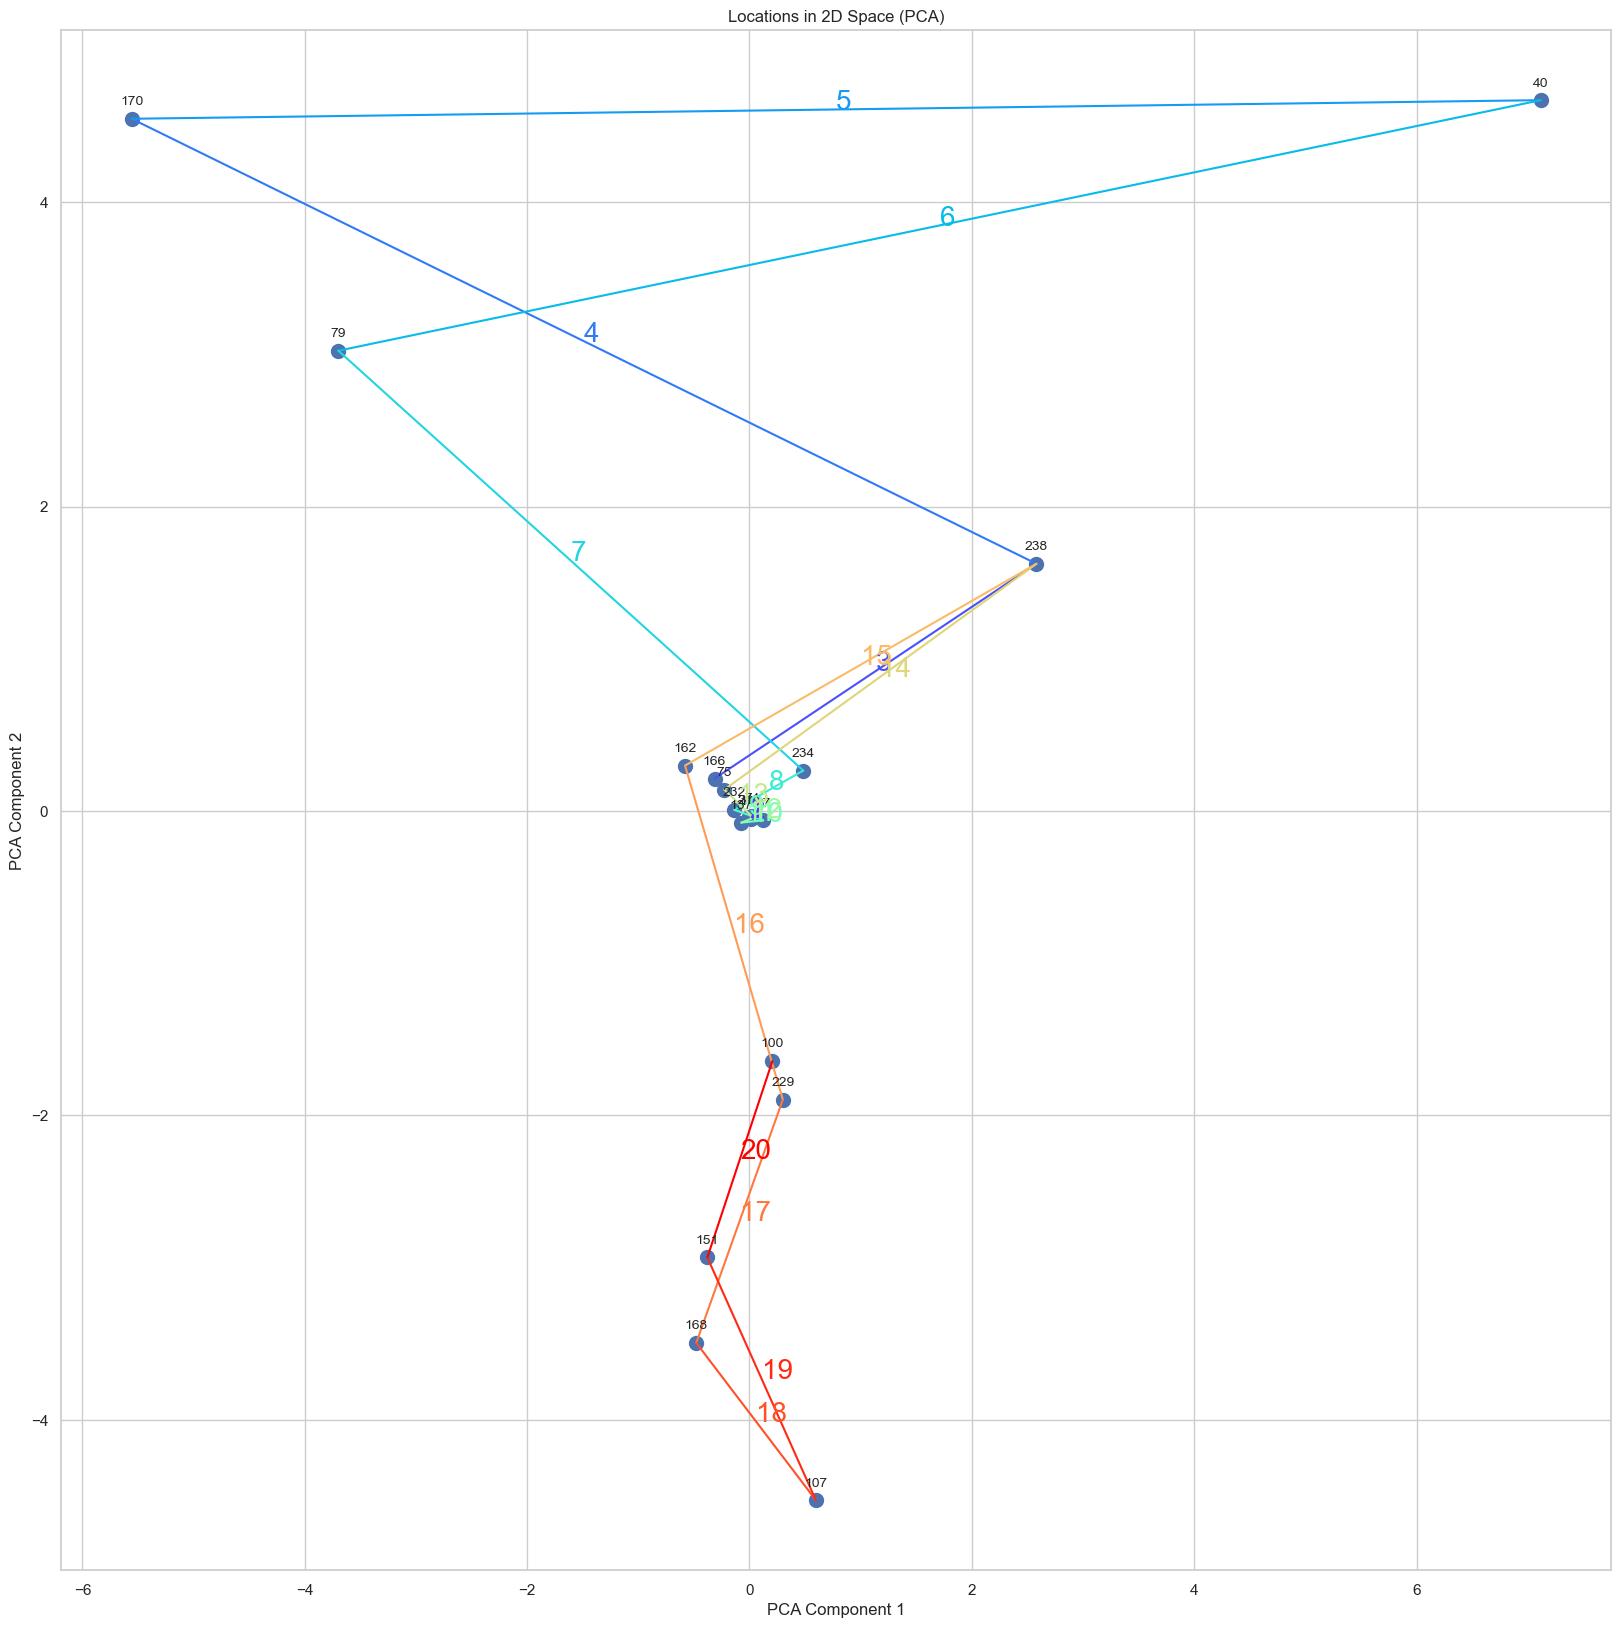

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
result_df = result[result['trip_distance'] != 0]

location_ids = np.unique(result_df[['PULocationID', 'DOLocationID']])
distance_matrix = np.zeros((len(location_ids), len(location_ids)))

for _, row in result_df.iterrows():
    i = np.where(location_ids == row['PULocationID'])[0][0]
    j = np.where(location_ids == row['DOLocationID'])[0][0]
    distance_matrix[i, j] = row['trip_distance']
    distance_matrix[j, i] = row['trip_distance']

# Perform PCA
pca = PCA(n_components=2)
coordinates = pca.fit_transform(distance_matrix)

# Plot the locations in 2D
plt.figure(figsize=(20, 20))
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=100)  # Larger point size

# Annotate the locations with their IDs
for i, location_id in enumerate(location_ids):
    plt.annotate(location_id, (coordinates[i, 0], coordinates[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)  # Larger font size

# Plot the routes with route numbers colored by route
colors = cm.rainbow(np.linspace(0, 1, len(result_df)))
for i, (_, row) in enumerate(result_df.iterrows()):
    pu_id = row['PULocationID']
    do_id = row['DOLocationID']
    pu_index = np.where(location_ids == pu_id)[0][0]
    do_index = np.where(location_ids == do_id)[0][0]
    plt.plot([coordinates[pu_index, 0], coordinates[do_index, 0]], [coordinates[pu_index, 1], coordinates[do_index, 1]], color=colors[i])
    plt.text((coordinates[pu_index, 0] + coordinates[do_index, 0]) / 2, (coordinates[pu_index, 1] + coordinates[do_index, 1]) / 2, str(i + 1), fontsize=20, color=colors[i])  # Larger font size

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Locations in 2D Space (PCA)')
plt.grid(True)
plt.show()


#### Now reducing the wating time

In [71]:
# Define a function for dynamic pricing
def calculate_fare(trip_distance,pas):
    base_fare = 3
    fare_per_mile = 2.18
   
    total_fare = base_fare + (fare_per_mile * trip_distance )
    return total_fare


In [74]:
import pandas as pd
import numpy as np

# Initialize variables
tim = 0
st = 145
result = pd.DataFrame()


# Iterate until 'tim' reaches 360 (changed from 300 to match the while loop condition)
while tim < 360:
    # Simulate passenger arrival and demand factor
    demand_factor = np.random.uniform(0.5, 1.5)  # Simulated demand factor
    x = passanger(1, st, tim)  # Assuming this function returns passenger count based on demand and location
    if x != 0:
        # Select a random row from 'next_trip' where 'PULocationID' matches 'st'
        ne = next_trip[next_trip['PULocationID'] == st].sample(n=1)
        ne['pass'] = int(x)
        
        # Calculate fare based on dynamic pricing and add to DataFrame
        ne['fare'] = calculate_fare(ne['trip_distance'].values[0], demand_factor)
        
        # Append the selected row to the 'result' DataFrame
        result = pd.concat([result, ne], ignore_index=True)
        
        # Update 'tim' and 'st'
        tim += ne['station_time'].values[0]
        st = ne['DOLocationID'].values[0]
    else:
        # Simulate idle time if no passengers
        tim += 1
        ne = pd.DataFrame({'PULocationID': [st], 'DOLocationID': [st], 'station_time': [tim], 'pass': [0], 'trip_distance': [0], 'fare': [0]})
        result = pd.concat([result, ne], ignore_index=True)

# Print the result
result


,PULocationID,DOLocationID,station_time,trip_distance,pass,fare
0,145,146,2.766667,0.5,1,4.090
1,146,161,10.500000,3.1,1,9.758
2,161,186,10.750000,1.5,1,6.270
3,186,107,8.983333,0.9,1,4.962
4,107,113,3.466667,0.5,1,4.090
...,...,...,...,...,...,...
186,53,53,356.700000,0.0,0,0.000
187,53,53,357.700000,0.0,0,0.000
188,53,53,358.700000,0.0,0,0.000
189,53,53,359.700000,0.0,0,0.000


In [75]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog



# Data initialization
tim = 0
st = 122
result = pd.DataFrame()
total_profit = 0

# Optimization parameters
max_time = 360
demand_threshold = 0.7  # Adjust as needed

# Linear programming formulation
c = [-1]  # Objective function coefficients (minimize negative profit)
A_eq = [[1]]  # Equality constraint coefficients (total time constraint)
b_eq = [max_time]  # Equality constraint constants

# Iterate until 'tim' reaches 'max_time'
while tim < max_time:
 
    # Simulate passenger arrival
    passengers = passanger(1, st,tim)

    # Select a random row from 'next_trip' where 'PULocationID' matches 'st'
    ne = next_trip[next_trip['PULocationID'] == st].sample(n=1)

    # Calculate fare based on dynamic pricing
    fare = calculate_fare(ne['trip_distance'].values[0], demand_factor)

    # Calculate profit
    profit = fare/2

    # Update total profit
    total_profit += profit

    # Append the selected row to the 'result' DataFrame
    result = pd.concat([result, ne], ignore_index=True)

    # Update 'tim' and 'st'
    tim += ne['station_time'].values[0]
    st = ne['DOLocationID'].values[0]

    # Constraint coefficients
    A_eq.append([ne['station_time'].values[0]])  # Time constraint
    b_eq.append(max_time - tim)  # Remaining time constraint

# Solve the linear programming problem
res = linprog(c, A_eq=A_eq, b_eq=b_eq)

# Check if the optimization was successful
if res.success:
    # Extract the optimal objective value (negative profit)
    optimal_profit = -res.fun
    print("Total profit (before optimization):", total_profit)
    print("Optimal profit (after optimization):", optimal_profit)
else:
    print("Optimization failed. No optimal solution found.")


Optimization failed. No optimal solution found.


In [76]:

def find_nearest_station(st):
    dd = next_trip[next_trip['PULocationID'] == st]
    if not dd.empty:
        dd = dd[dd['station_time'] == dd['station_time'].min()]
        sta = dd['DOLocationID'].unique()[0]
        ti = dd['station_time'].unique()[0]
        pas = passanger(1, sta, tim + ti)
        return sta, pas
    else:
        return None, None


In [81]:
import pandas as pd
import numpy as np

def run_simulation(dt):
    # Initialize variables
    tim = 0
    st = 122
    result = pd.DataFrame()

    

    # Main simulation loop
    while tim < 360:
       
        x = passanger(dt,st,tim)  

        if x != 0:
            ne = next_trip[next_trip['PULocationID'] == st].sample(n=1)
            ne['pass'] = x
            ne['fare'] = calculate_fare(ne['trip_distance'].values[0], x)
            result = pd.concat([result, ne], ignore_index=True)
            tim += ne['station_time'].values[0]
            st = ne['DOLocationID'].values[0]
        else:
            loss = find_nearest_station(st)
            nearest_station = loss[0]

            if nearest_station is not None:
                # Check if waiting at the current station is more profitable
                current_loss =1 
                vi = [3,5,7,10,13,16,18,20]
                for i in vi:
                    t = passanger(dt,st,tim)
                    if t != 0:
                        current_loss = i
                        break
                
                next_loss = loss[1] 
                if current_loss < next_loss/2:
                    # It's more profitable to wait at the current station
                    tim += current_loss
                    ne = pd.DataFrame({'PULocationID': [st], 'DOLocationID': [st], 'station_time': [tim], 'pass': [0], 'trip_distance': [0], 'fare': [0]})
                    result = pd.concat([result, ne], ignore_index=True)
                else:
                    # Move to the nearest station 
                    ne = pd.DataFrame({'PULocationID': [st], 'DOLocationID': [nearest_station], 'station_time': [tim], 'pass': [0], 'trip_distance': [0], 'fare': [0]})
                    result = pd.concat([result, ne], ignore_index=True)
                    tim += ne['station_time'].values[0]
                    st = nearest_station
                    ne = next_trip[next_trip['PULocationID'] == nearest_station].sample(n=1)
                    ne['pass'] = t
                    ne['fare'] = calculate_fare(ne['trip_distance'].values[0], t)
                    result = pd.concat([result, ne], ignore_index=True)
                    tim += ne['station_time'].values[0]
                    st = ne['DOLocationID'].values[0]
            else:
                # If no station with passengers nearby, wait for one time unit
                tim += 1
                ne = pd.DataFrame({'PULocationID': [st], 'DOLocationID': [st], 'station_time': [tim], 'pass': [0], 'trip_distance': [0], 'fare': [0]})
                result = pd.concat([result, ne], ignore_index=True)

    return result

# Run the simulation
xx =run_simulation(1)
xx


,PULocationID,DOLocationID,station_time,trip_distance,pass,fare
0,122,74,24.516667,0.0,1.000000,3.000
1,74,75,5.400000,1.0,1.002243,5.180
2,75,151,4.466667,1.0,1.003631,5.180
3,151,238,4.566667,0.6,1.009105,4.308
4,238,143,7.350000,1.1,1.013734,5.398
5,143,140,13.650000,2.3,1.011402,8.014
6,140,186,19.400000,3.3,1.009892,10.194
7,186,48,15.933333,2.0,1.018479,7.360
8,48,148,25.483333,4.0,1.036293,11.720
9,148,40,15.433333,3.6,1.048944,10.848


In [82]:
xx['fare'].sum()

129.96800000000002

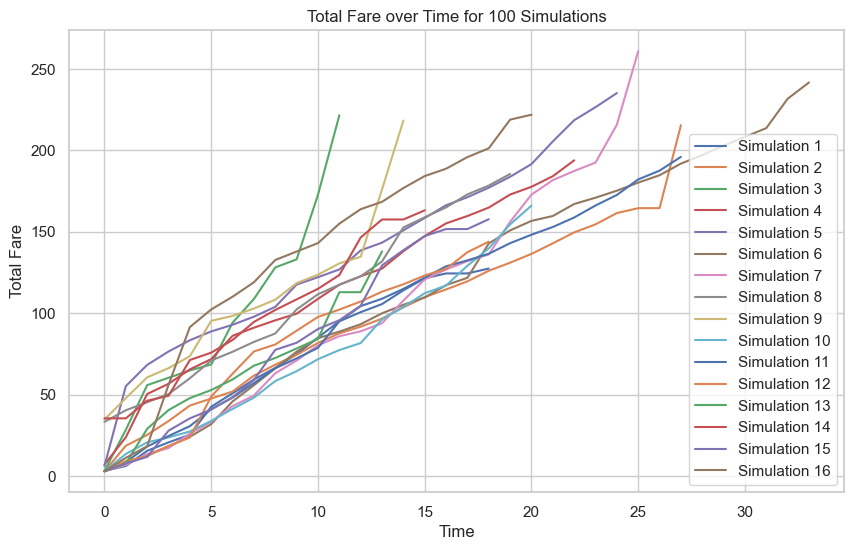

In [80]:
# List to store the results of each simulation
results_list = []

# Run the simulation 100 times
for _ in range(25):
    try:
        results_list.append(run_simulation(1))
    except Exception as e:
        pass

# Plot the results
plt.figure(figsize=(10, 6))
for i, result in enumerate(results_list):
    plt.plot(result.index, result['fare'].cumsum(), label=f'Simulation {i+1}')

plt.xlabel('Time')
plt.ylabel('Total Fare')
plt.title('Total Fare over Time for 100 Simulations')

plt.grid(True)
plt.legend()
plt.show()


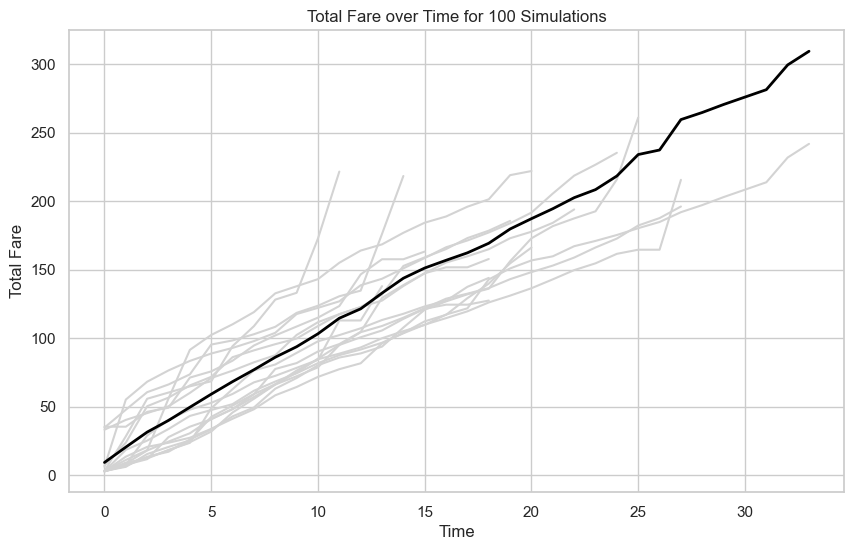

In [83]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot individual simulations
for i, result in enumerate(results_list):
    plt.plot(result.index, result['fare'].cumsum(), label=f'Simulation {i+1}', color='lightgrey')

# Compute and plot the average simulation
avg_result = pd.concat(results_list).groupby(level=0).mean()
avg_result_shortened = avg_result  
plt.plot(avg_result_shortened.index, avg_result_shortened['fare'].cumsum(), label='Average Simulation', color='black', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Total Fare')
plt.title('Total Fare over Time for 100 Simulations')
#plt.legend()
plt.grid(True)
plt.show()

In [84]:
# Concatenate all simulation results
concatenated_results = pd.concat(results_list)

# Group by time step and compute the sum of fares for each time step
sum_of_fares = concatenated_results.groupby(level=0)['fare'].sum()

# Compute the mean fare for each time step
mean_fares = sum_of_fares / len(results_list)

# Print or use mean_fares as needed
mean_fares.sum()

192.948125

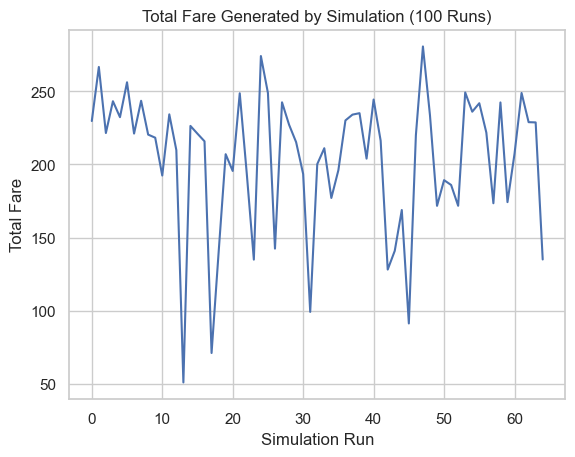

In [85]:
# Initialize an empty list to store the total fares for each run
total_fares = []

# Run the simulation 100 times and calculate the total fare for each run
for _ in range(100):
    try:
        total_fare = run_simulation(1)['fare'].sum()
        total_fares.append(total_fare)
    except Exception as e:
        pass

# Plot the total fare for each run
plt.plot(range(len(total_fares)), total_fares)
plt.xlabel('Simulation Run')
plt.ylabel('Total Fare')
plt.title('Total Fare Generated by Simulation (100 Runs)')
plt.show()


#### On avergae $ 200 can be earned 